# Linear system test


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

from datafold.appfold import EDMD
from datafold.dynfold import DMDFull
from datafold.dynfold.transform import TSCPolynomialFeatures, TSCRadialBasis
from datafold.pcfold import GaussianKernel, TSCDataFrame

## Set up ODE system

We set up a Hopf ODE system:

$$
\dot{x} = A x\\
x \in \mathbb{R}^{10}\\
$$





We solve the system by integration with a Runge-Kutta45 scheme using scipy's ODE solver. The return type of this function is a `TSCDataFrame` and includes the time series for each initial condition (a row in argument `initial_conditions`).

In [3]:
A = np.array([[0.9, -0.1], [0, 0.8]])
A

array([[ 0.9, -0.1],
       [ 0. ,  0.8]])

In [4]:
np.linalg.matrix_rank(A)

2

In [5]:
def solve_linear_system(initial_conditions, t_eval):
    def limit_cycle(t, y):
        """ODE system."""
        mu = 1
        y_dot = np.zeros(2)

        factor = mu - y[0] ** 2 - y[1] ** 2

        y_dot[0] = -y[1] + y[0] * factor
        y_dot[1] = y[0] + y[1] * factor
        return y_dot
    
    def linear_system(t, y):
        """ODE system."""
        y_dot = A @ y
        return y_dot

    assert initial_conditions.ndim == 2
    assert initial_conditions.shape[1] == 2

    time_series_dfs = []

    for ic in initial_conditions:
        solution = solve_ivp(
            linear_system, t_span=(t_eval[0], t_eval[-1]), y0=ic, t_eval=t_eval
        )

        solution = pd.DataFrame(
            data=solution["y"].T,
            index=solution["t"],
            columns=["x1", "x2"],
        )

        time_series_dfs.append(solution)

    return TSCDataFrame.from_frame_list(time_series_dfs)

## Sampling the dynamical system

We now start collecting time series data from the Linear system (our training set). To sample the phase space, we systematically distribute initial conditions and solve the ODE system for rather short time intervals.

In [6]:
initial_conditions = np.array(
    np.meshgrid(np.linspace(-2, 2, 20), np.linspace(-2, 2, 20))
).T.reshape(-1, 2)


initial_conditions.shape

(400, 2)

In [7]:
time_series_dfs = []

for ic in initial_conditions:
    solution = A @ ic
#     print(solution)

    solution = pd.DataFrame(
        data= np.array([ic, solution]),
        index=[0,1],
        columns=["x1", "x2"],
    )

    time_series_dfs.append(solution)

tsc_data = TSCDataFrame.from_frame_list(time_series_dfs)
tsc_data

feature         x1        x2
ID  time                    
0   0    -2.000000 -2.000000
    1    -1.600000 -1.600000
1   0    -2.000000 -1.789474
    1    -1.621053 -1.431579
2   0    -2.000000 -1.578947
...            ...       ...
397 1     1.642105  1.263158
398 0     2.000000  1.789474
    1     1.621053  1.431579
399 0     2.000000  2.000000
    1     1.600000  1.600000

[800 rows x 2 columns]

### Plot: Sampled time series used for training

In [8]:
# function to add a single arrow in the following time series plots
idx_arrow = np.array([0,1])


def include_arrow(ax, df):
    arrow = df.iloc[idx_arrow, :]
    ax.arrow(
        arrow.iloc[0, 0],
        arrow.iloc[0, 1],
        dx=arrow.iloc[1, 0] - arrow.iloc[0, 0],
        dy=arrow.iloc[1, 1] - arrow.iloc[0, 1],
        color="black",
        head_width=0.05,
    )

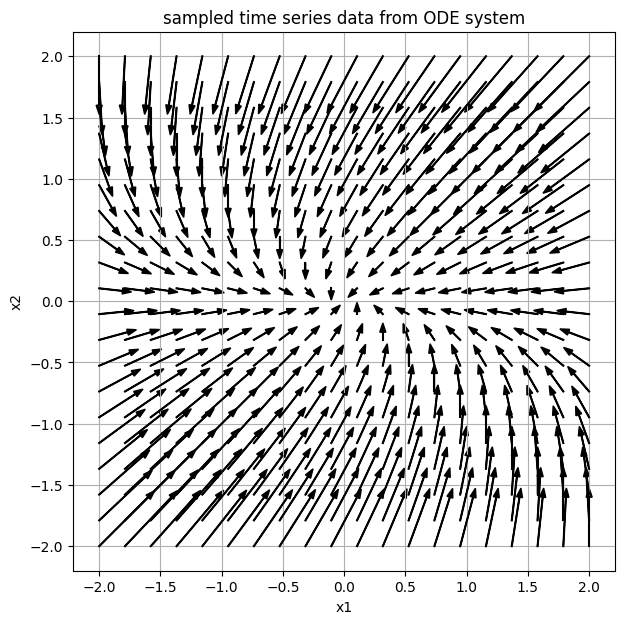

In [9]:
fig, ax = plt.subplots(figsize=[7, 7])

for _id, df in tsc_data.itertimeseries():
    ax.plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax, df)

ax.set_title("sampled time series data from ODE system")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.axis("equal")
ax.grid();

## 1. DMD: Identity dictionary

In our first model, we use a Dynamic Mode Decomposition (in `datafold.dynfold.dmd`) model and decompose the data in spatio-temporal coordinates using the original form of the time series. In other words, our dictionary only includes the state identities "x1" and "x2" as observable functions. 

In the first attempt, we use the `DMDFull` model directly. The same could be accomplished with `EDMD(dict_step=["id", TSCIdentity()]`).

Note that the DMD-based models' API aligns with scikit-learn. However, the input type of `X` is restricted to a `TSCDataFrame`. The `predict` method allows setting an array of `time_values`, where we can choose at which time samples to evaluate the model. In our case, we are interested in reconstructing the training data, we leave the parameter `time_values=None`. The model then uses the same time values that were available during `fit`.

In [10]:
dmd = DMDFull().fit(X=tsc_data, store_system_matrix=True)  # must be TSCDataFrame
dmd_values = dmd.predict(tsc_data.initial_states(), time_values=None)

# Will be a red line in the plot
dmd_values_oos = dmd.predict(np.array([-1.8, 2]), time_values=np.linspace(0, 2, 100))

print("Data snipped with predicted time series data")
dmd_values

Data snipped with predicted time series data


feature         x1        x2
ID  time                    
0   0    -2.000000 -2.000000
    1    -1.600000 -1.600000
1   0    -2.000000 -1.789474
    1    -1.621053 -1.431579
2   0    -2.000000 -1.578947
...            ...       ...
397 1     1.642105  1.263158
398 0     2.000000  1.789474
    1     1.621053  1.431579
399 0     2.000000  2.000000
    1     1.600000  1.600000

[800 rows x 2 columns]

In [11]:
dmd_values_oos

feature            x1        x2
ID time                        
0  0.000000 -1.800000  2.000000
   0.020202 -1.800916  1.991004
   0.040404 -1.801809  1.982049
   0.060606 -1.802678  1.973134
   0.080808 -1.803525  1.964260
...               ...       ...
   1.919192 -1.801028  1.303290
   1.939394 -1.800289  1.297428
   1.959596 -1.799538  1.291593
   1.979798 -1.798775  1.285783
   2.000000 -1.798000  1.280000

[100 rows x 2 columns]

### Compare with training data 

We can now compare the original time series data with the data-driven reconstruction of the DMD model. From what we see in the plots below is that the DMD model performs poorly. This is not surprising at this stage, because we learn the Koopman matrix directly on the available states. The computed Koopman matrix is therefore a $K \in \mathbb{R}^{[2 \times 2]}$ describing a linear system

$$ x_{n+1} = K x_n $$

and not being able to desribe a complex dynamics such as this of the underlying system. Note that the learnt system equation implies that we have modelled a dicrete system, while the underling system is continuous. This is a result from the discretely sampled data with a fixed time interval. Because we are in this easier setting of a 2-by-2 matrix, in the next cell, we look at the relation to a continuous system.

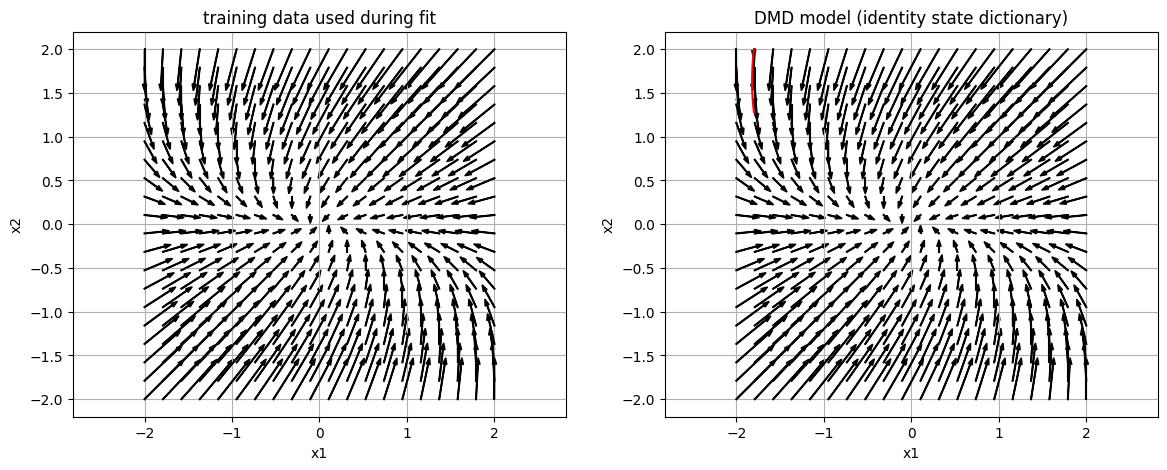

In [12]:
f, ax = plt.subplots(1, 2, figsize=(14, 5))
for _id, df in tsc_data.itertimeseries():
    ax[0].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax[0], df)

ax[0].set_title("training data used during fit")
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
ax[0].axis("equal")
ax[0].grid()

for _id, df in dmd_values.itertimeseries():
    ax[1].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax[1], df)

ax[1].set_title("DMD model (identity state dictionary)")
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")
ax[1].axis("equal")
ax[1].grid()


# generate red "out-of-sample" prediction, for extra analysis below
ax[1].plot(dmd_values_oos["x1"], dmd_values_oos["x2"], 0.1, c="red")
include_arrow(ax[1], dmd_values_oos)

### Connection of discrete and continuous linear dynamical system

We start with the form of a continuous linear dynamical system

$$ \frac{dx}{dt} = A x $$

where $A$ is a constant system matrix. To connect this representation to our learnt discrete system ($x_{n+1} = K x_n$), we first discretize the time derivative on the left hand side with a usual forward finite difference

$$\frac{x_{n+1} - x_{n}}{\tau} = A x_n$$

where we set $\tau$ to the time sampling interval of the available time series data (in the data from the Hopf system $\tau = 0.02$). This is again a discrete system; then by rearranging the equation to the future state $x_{n+1}$ reveals

$$x_{n+1} = \underbrace{(I + \tau \cdot A)}_K x_n$$

We can then analyze both system matrices -- either in terms of a discrete system $K$ or via the continuous system matrix $A$.

$$A = \frac{K - I}{\tau}$$

Because we are still in the case of $A \in \mathbb{R}^{[2 \times 2]}$, where the observable states to approximate $K$ directly match the original states, we can now look at the the phase portrait and apply [stability theory](https://en.wikipedia.org/wiki/Stability_theory). With the computed values below, $\operatorname{trace}(A)$ and $\operatorname{det}{A}$, we can classify our current system as a "spiral sink" -- the determinant is larger than $\Delta$ and the trace is negative; see Poincaré diagram in the stability theory article. This matches the fast decaying red trajectory in the plot above.

Because the underlying Hopf system, that we aim to model, has quite different dynamics than a spiral sink, we continue our tutorial to improve the quality of our model.

In [13]:
generator_A = (dmd.koopman_matrix_ - np.eye(2)) / dmd.dt_

det = np.linalg.det(generator_A)
trace = np.trace(generator_A)

print("Relevant values for the stability analysis: \n")
print(f"determinant of A: {det}")
print(f"trace of A: {trace}")

print(f"Delta {1/4. * trace ** 2} ")

Relevant values for the stability analysis: 

determinant of A: 0.019999999999999993
trace of A: -0.2999999999999996
Delta 0.02249999999999994 


## 2. EDMD: Polynomial feature dictionary

We now get to the "extended" part of a Dynamic Model Decomposition: We define a *dictionary* in which we process the time series data before we fit a DMD model with it. For this, we use the `datafold.appfold.EDMD` class, which is a [`sklearn.pipeline.Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html?highlight=pipeline#sklearn.pipeline.Pipeline). In the `EDMD` model, a dictionary can be a flexible number of transform models that are process the time series data consecutively (in the same order as defined). The final estimator has to be a `datafold.dynfold.dmd.DMDBase` model and defaults to `DMDFull`.  

Choosing the "right" dictionary is not an easy task and is similar to "model selection" in classical machine learning. In our choice of dictionary, we can include expert knowledge, e.g. if we know the principle equations from an underlying physical system from which time series are collected. We can also apply methods from functional theory to represent the data in another basis to linearize the unknown dynamics manifold. 

In the first dictionary, we use `TSCPolynomialFeatures` which is a wrapper of [`sklearn.preprocessing.PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html?highlight=polynomial#sklearn.preprocessing.PolynomialFeatures) to support `TSCDataFrame` type.

In [14]:
dict_step = [
    (
        "polynomial",
        TSCPolynomialFeatures(degree=3),
    )
]

edmd_poly = EDMD(dict_steps=dict_step, include_id_state=True).fit(X=tsc_data)
edmd_poly_values = edmd_poly.predict(tsc_data.initial_states())

In [15]:
edmd_poly.feature_names_out_

Index(['x1', 'x2', 'x1^2', 'x1 x2', 'x2^2', 'x1^3', 'x1^2 x2', 'x1 x2^2',
       'x2^3'],
      dtype='object', name='feature')

### Analyze the dictionary

Before we compare the model's time series data to the training data, we investigate how we to analyze the actual process of dictionary transformations in an `EDMD` model.  

This is useful if we are interested and want to investigate the values of the "dictionary space", i.e. the data representation after the transformations were applied to the original data and before it is passed to the final DMD model. To accomblish this we can use the `transform` method of `EDMD`, which only applies the dictionary transformations without processing it through the final estimator. 

In the following cell, we see that the result is a `TSCDataFrame`, which includes the original states "x1" and "x2" plus the generated polynomial features. 

The single dictionary models are accessible with the specified name via `named_steps`. Here, we access the model and its attribute `TSCPolynomialFeatures.powers_` through the `EDMD` model.

In [16]:
# access models in the dictionary, the name was given in "dict_step" above
print(edmd_poly.named_steps["polynomial"])

print("")
print("polynomial degrees for data (first column 'x1' and second 'x2'):")
print(edmd_poly.named_steps["polynomial"].powers_)

print("")
print("Dictionary space values:")
edmd_poly.transform(tsc_data)

TSCPolynomialFeatures(degree=3)

polynomial degrees for data (first column 'x1' and second 'x2'):
[[2 0]
 [1 1]
 [0 2]
 [3 0]
 [2 1]
 [1 2]
 [0 3]]

Dictionary space values:


feature         x1        x2      x1^2     x1 x2      x2^2      x1^3  \
ID  time                                                               
0   0    -2.000000 -2.000000  4.000000  4.000000  4.000000 -8.000000   
    1    -1.600000 -1.600000  2.560000  2.560000  2.560000 -4.096000   
1   0    -2.000000 -1.789474  4.000000  3.578947  3.202216 -8.000000   
    1    -1.621053 -1.431579  2.627812  2.320665  2.049418 -4.259821   
2   0    -2.000000 -1.578947  4.000000  3.157895  2.493075 -8.000000   
...            ...       ...       ...       ...       ...       ...   
397 1     1.642105  1.263158  2.696510  2.074238  1.595568  4.427953   
398 0     2.000000  1.789474  4.000000  3.578947  3.202216  8.000000   
    1     1.621053  1.431579  2.627812  2.320665  2.049418  4.259821   
399 0     2.000000  2.000000  4.000000  4.000000  4.000000  8.000000   
    1     1.600000  1.600000  2.560000  2.560000  2.560000  4.096000   

feature    x1^2 x2   x1 x2^2      x2^3  
ID  time                                
0   0    -8.000000 -8.000000 -8.000000  
    1    -4.096000 -4.096000 -4.096000  
1   0    -7.157895 -6.404432 -5.730281  
    1    -3.761920 -3.322215 -2.933904  
2   0    -6.315789 -4.986150 -3.936434  
...            ...       ...       ...  
397 1     3.406118  2.620090  2.015454  
398 0     7.157895  6.404432  5.730281  
    1     3.761920  3.322215  2.933904  
399 0     8.000000  8.000000  8.000000  
    1     4.096000  4.096000  4.096000  

[800 rows x 9 columns]

### Compare with training data

We see that reconstruction of time series improved and the phase portrait now looks a lot better than the previous DMD approach. However, there are still obvious differences and some time series even cross, which is not a behaviour of the original system.

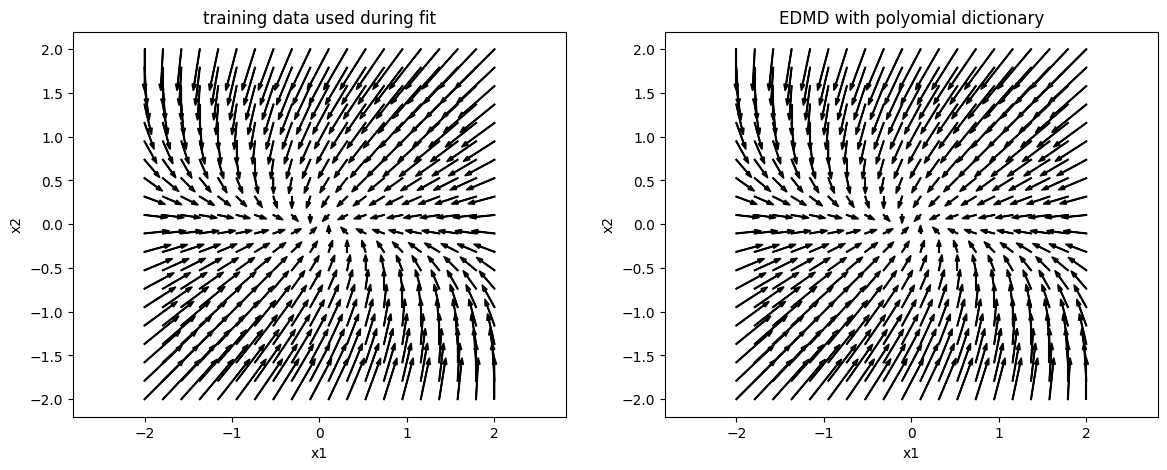

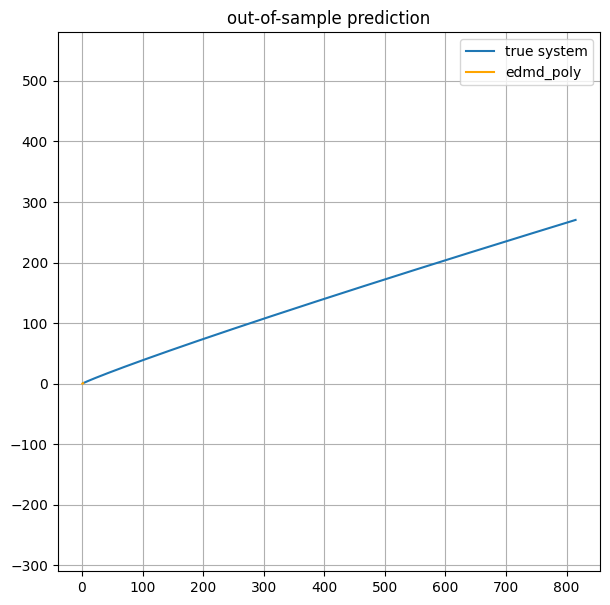

In [17]:
f, ax = plt.subplots(1, 2, figsize=(14, 5))
for _id, df in tsc_data.itertimeseries():
    ax[0].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax[0], df)

ax[0].set_title("training data used during fit")
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
ax[0].axis("equal")

for _id, df in edmd_poly_values.itertimeseries():
    ax[1].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax[1], df)

ax[1].set_title("EDMD with polyomial dictionary")
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")
ax[1].axis("equal");

# make out-of-sample prediction
initial_condition = np.array([[2, 1]])
t_eval = np.linspace(0, 7, 400)

ground_truth = solve_linear_system(initial_condition, t_eval)
predicted = edmd_poly.predict(initial_condition, t_eval)

f, ax = plt.subplots(figsize=(7, 7))

ax.plot(ground_truth.loc[:, "x1"], ground_truth.loc[:, "x2"], label="true system")
include_arrow(ax, ground_truth)
ax.plot(predicted.loc[:, "x1"], predicted.loc[:, "x2"], c="orange", label="edmd_poly")

ax.set_title("out-of-sample prediction")
ax.axis("equal")
ax.grid()
ax.legend()

## 3. EDMD: Radial basis function dictionary

In our last attempt, we set up a dictionary with `TSCRadialBasis`. The transform class computes coefficients of each time series sample to a set of radial basis functions, which centres' are distributed on the phase space. The radial basis functions, therefore, provide a way to linearize the phase space's manifold. Here we choose a Gaussian kernel and set the centre of the functions to the initial condition states.

In the time series in "dictionary space," we see that the feature dimension is now much greater than at the beginning (i.e. we provide a larger set of observables to compute the Koopman operator).

In [18]:
dict_step = [
    (
        "rbf",
        TSCRadialBasis(
            kernel=GaussianKernel(epsilon=0.17), center_type="initial_condition"
        ),
    )
]

edmd_rbf = EDMD(dict_steps=dict_step, include_id_state=True).fit(
    X=tsc_data
)  # Note that the "extended" part is in the transformations
edmd_rbf_values = edmd_rbf.predict(tsc_data.initial_states())

len_koopman_matrix = len(edmd_rbf.named_steps["dmd"].eigenvectors_right_)
print(f"shape of Koopman matrix: {len_koopman_matrix} x {len_koopman_matrix}")
edmd_rbf.transform(tsc_data)

/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/datafold/dynfold/dmd.py:1169: UserWarning: There are more observables than snapshots. The current implementation favors more snapshots than obserables. This may result in a bad computational performance.
  warnings.warn(
/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/datafold/dynfold/dmd.py:1187: UserWarning: Shift matrix (shape=(402, 402)) has not full rank (=288), falling back to least squares solution. The sum of residuals is: 0.0
  warnings.warn(


shape of Koopman matrix: 402 x 402


feature         x1        x2          rbf0          rbf1          rbf2  \
ID  time                                                                 
0   0    -2.000000 -2.000000  1.000000e+00  8.777821e-01  5.936725e-01   
    1    -1.600000 -1.600000  3.901685e-01  5.620428e-01  6.238210e-01   
1   0    -2.000000 -1.789474  8.777821e-01  1.000000e+00  8.777821e-01   
    1    -1.621053 -1.431579  2.534325e-01  4.497392e-01  6.149397e-01   
2   0    -2.000000 -1.578947  5.936725e-01  8.777821e-01  1.000000e+00   
...            ...       ...           ...           ...           ...   
397 1     1.642105  1.263158  2.850237e-31  1.423242e-29  5.475832e-28   
398 0     2.000000  1.789474  1.659266e-39  1.589938e-37  1.173864e-35   
    1     1.621053  1.431579  1.621643e-32  9.975493e-31  4.728103e-29   
399 0     2.000000  2.000000  1.334213e-41  1.659266e-39  1.589938e-37   
    1     1.600000  1.600000  7.788116e-34  5.901912e-32  3.446089e-30   

feature           rbf3          rbf4          rbf5          rbf6  \
ID  time                                                           
0   0     3.093717e-01  1.242189e-01  3.842983e-02  9.160572e-03   
    1     5.334873e-01  3.515294e-01  1.784731e-01  6.981636e-02   
1   0     5.936725e-01  3.093717e-01  1.242189e-01  3.842983e-02   
    1     6.478550e-01  5.258921e-01  3.289189e-01  1.585093e-01   
2   0     8.777821e-01  5.936725e-01  3.093717e-01  1.242189e-01   
...                ...           ...           ...           ...   
397 1     1.623285e-26  3.707773e-25  6.525366e-24  8.848510e-23   
398 0     6.677729e-34  2.926937e-32  9.884881e-31  2.572190e-29   
    1     1.726684e-27  4.858614e-26  1.053381e-24  1.759672e-23   
399 0     1.173864e-35  6.677729e-34  2.926937e-32  9.884881e-31   
    1     1.550364e-28  5.374207e-27  1.435386e-25  2.953903e-24   

feature           rbf7  ...        rbf390        rbf391        rbf392  \
ID  time                ...                                             
0   0     1.682481e-03  ...  7.966847e-27  5.157129e-28  2.572190e-29   
    1     2.104337e-02  ...  5.386667e-21  5.722319e-22  4.683790e-23   
1   0     9.160572e-03  ...  9.482840e-26  7.966847e-27  5.157129e-28   
    1     5.885642e-02  ...  1.716374e-20  2.246183e-21  2.264914e-22   
2   0     3.842983e-02  ...  8.696888e-25  9.482840e-26  7.966847e-27   
...                ...  ...           ...           ...           ...   
397 1     9.245041e-22  ...  1.329954e-02  4.897440e-02  1.389553e-01   
398 0     5.157129e-28  ...  2.380955e-04  1.682481e-03  9.160572e-03   
    1     2.264914e-22  ...  3.711869e-03  1.683862e-02  5.885642e-02   
399 0     2.572190e-29  ...  2.596126e-05  2.380955e-04  1.682481e-03   
    1     4.683790e-23  ...  8.744835e-04  4.887049e-03  2.104337e-02   

feature         rbf393        rbf394        rbf395        rbf396  \
ID  time                                                           
0   0     9.884881e-31  2.926937e-32  6.677729e-34  1.173864e-35   
    1     2.953903e-24  1.435386e-25  5.374207e-27  1.550364e-28   
1   0     2.572190e-29  9.884881e-31  2.926937e-32  6.677729e-34   
    1     1.759672e-23  1.053381e-24  4.858614e-26  1.726684e-27   
2   0     5.157129e-28  2.572190e-29  9.884881e-31  2.926937e-32   
...                ...           ...           ...           ...   
397 1     3.037769e-01  5.116911e-01  6.641013e-01  6.641013e-01   
398 0     3.842983e-02  1.242189e-01  3.093717e-01  5.936725e-01   
    1     1.585093e-01  3.289189e-01  5.258921e-01  6.478550e-01   
399 0     9.160572e-03  3.842983e-02  1.242189e-01  3.093717e-01   
    1     6.981636e-02  1.784731e-01  3.515294e-01  5.334873e-01   

feature         rbf397        rbf398        rbf399  
ID  time                                            
0   0     1.589938e-37  1.659266e-39  1.334213e-41  
    1     3.446089e-30  5.901912e-32  7.788116e-34  
1   0     1.173864e-35  1.589938e-37  1.659266e-39  
    1     4.728103e-29  9.975493e-31  1.621643e-32  

### Compare with training data

Again for comparison, we plot the training time series next to the EDMD model's time series. This time the phase portraits match quite well. However, at this stage, this is only an indicator of a successful model. Like for all data-driven machine learning models, there is always the danger of overfitting the training data. A consequence would be a poor generalization for out-of-sample initial conditions. 

The right way to tackle overfitting is to apply cross-validation. For the `EDMD` model this can be achieved with `EDMDCV`, which allows an exhaustive search over a grid of the model's and the dictionary model parameters. *datafold* provides time series splitting for cross-validation which enables measuring the model's quality on unseen (partial) time series data.

In this tutorial, we only add a single out-of-sample initial condition and compare it to the ODE system for a longer time series as in the training data. We used this plot to visually "optimize" the Gaussian kernel epsilon value. If we now predict the time series we want to highlight that the `EDMD` model interpolates in time. This means we are now able to freely choose the time interval and number of time samples at which to evaluate the model. In the time series we can see that the model follows the ground truth solution fairly well for some time. However, the `EDMD` model won't stay on the attractor for $t \rightarrow \infty$ yet.

The problem of overfitting can be seen if `epsilon=1` is set in the Gaussian kernel. The reconstruction phase portrait looks equally well, but the out-of-sample quality decreases. 

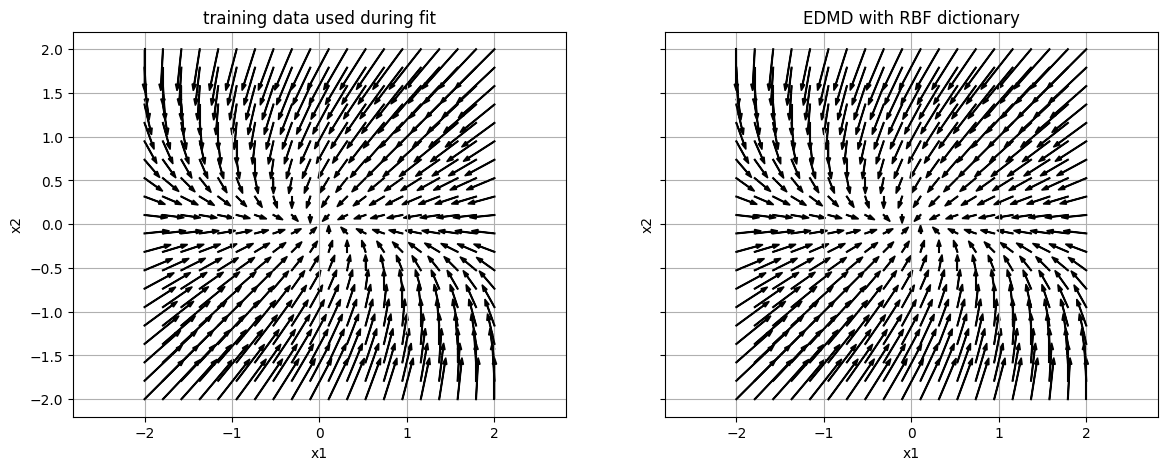

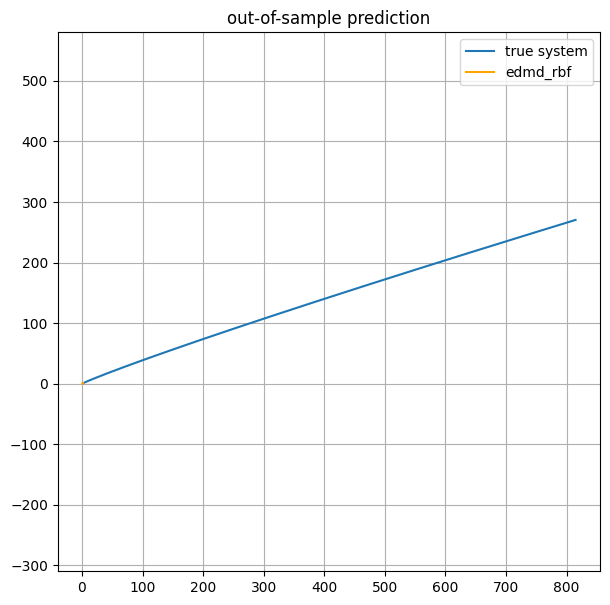

In [19]:
f, ax = plt.subplots(1, 2, sharey=True, figsize=(14, 5))
for _id, df in tsc_data.itertimeseries():
    ax[0].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax[0], df)

ax[0].set_title("training data used during fit")
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
ax[0].axis("equal")
ax[0].grid()

for _id, df in edmd_rbf_values.itertimeseries():
    ax[1].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax[1], df)

ax[1].set_title("EDMD with RBF dictionary")
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")
ax[1].axis("equal")
ax[1].grid()


# make out-of-sample prediction
initial_condition = np.array([[2, 1]])
t_eval = np.linspace(0, 7, 400)

ground_truth = solve_linear_system(initial_condition, t_eval)
predicted = edmd_rbf.predict(initial_condition, t_eval)

f, ax = plt.subplots(figsize=(7, 7))

ax.plot(ground_truth.loc[:, "x1"], ground_truth.loc[:, "x2"], label="true system")
include_arrow(ax, ground_truth)
ax.plot(predicted.loc[:, "x1"], predicted.loc[:, "x2"], c="orange", label="edmd_rbf")

ax.set_title("out-of-sample prediction")
ax.axis("equal")
ax.grid()
ax.legend()

### using polynomial dictionary and comparing with explicit eigenfunctions

In [20]:
edmd_poly.koopman_eigenfunction(tsc_data)

feature   koop_eigfunc0  koop_eigfunc1  koop_eigfunc2  koop_eigfunc3  \
ID  time                                                               
0   0      3.753726e-14  -2.096545e-12       2.828427  -3.735394e-13   
    1      3.406318e-14  -1.708411e-12       2.262742  -2.752624e-13   
1   0     -2.105263e-01   4.432133e-02       2.530698   9.330806e-03   
    1     -1.894737e-01   3.590028e-02       2.024558   6.802158e-03   
2   0     -4.210526e-01   1.772853e-01       2.232969   7.464645e-02   
...                 ...            ...            ...            ...   
397 1      3.789474e-01   1.436011e-01      -1.786375  -5.441726e-02   
398 0      2.105263e-01   4.432133e-02      -2.530698  -9.330806e-03   
    1      1.894737e-01   3.590028e-02      -2.024558  -6.802158e-03   
399 0     -6.754721e-14   2.220890e-12      -2.828427   7.286788e-13   
    1     -5.327732e-14   1.783018e-12      -2.262742   5.043059e-13   

feature   koop_eigfunc4  koop_eigfunc5  koop_eigfunc6  koop_eigfunc7  \
ID  time                                                               
0   0     -2.296883e-13   1.819405e-12       6.928203  -2.563894e-13   
    1     -1.673029e-13   1.153693e-12       4.434050  -1.600010e-13   
1   0      8.423968e-01  -2.508061e-01       5.546401   2.522441e+00   
    1      6.065257e-01  -1.625224e-01       3.549697   1.452926e+00   
2   0      1.486583e+00  -8.851980e-01       4.318132   3.927677e+00   
...                 ...            ...            ...            ...   
397 1      1.070339e+00   5.736083e-01       2.763605  -2.262342e+00   
398 0      8.423968e-01   2.508061e-01       5.546401  -2.522441e+00   
    1      6.065257e-01   1.625224e-01       3.549697  -1.452926e+00   
399 0      4.177920e-14   2.391769e-12       6.928203   8.278863e-14   
    1      5.230447e-14   1.527710e-12       4.434050   3.614296e-14   

feature   koop_eigfunc8  
ID  time                 
0   0         16.000000  
    1          8.192000  
1   0         11.460563  
    1          5.867808  
2   0          7.872868  
...                 ...  
397 1         -4.030908  
398 0        -11.460563  
    1         -5.867808  
399 0        -16.000000  
    1         -8.192000  

[800 rows x 9 columns]

In [21]:
A

array([[ 0.9, -0.1],
       [ 0. ,  0.8]])

In [22]:
# explicit eigenfunctions and eigenvalues

eigvalue_i = 0.9
eigvalue_j = 0.8

def eigenfunction_i(x,y):
    return (x-y)/np.sqrt(2)

def eigenfunction_j(x,y):
    return y

In [23]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

In [24]:
def eigenfunction_ij(x,y):
    return eigenfunction_i(x,y) * eigenfunction_j(x,y)

In [317]:
def eigfunction_generate(x, y, m = 1, n = 1):
    
    p = 1
    for i in range(m):
        p = p * eigenfunction_i(x,y)
    
    for i in range(n):
        p = p * eigenfunction_j(x,y)
    
    return p

In [254]:
eig_dict = {}
for m in range(4):
    for n in range(4):
        if m+n>3:
            continue
        if m==0 and n==0:
            continue
        eig = (eigvalue_i)**m * (eigvalue_j) ** n
        eig_dict[(m,n)] = eig
    
sorted_eig = sorted(eig_dict, key=eig_dict.get, reverse=True)
sorted_eig

[(1, 0), (2, 0), (0, 1), (3, 0), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]

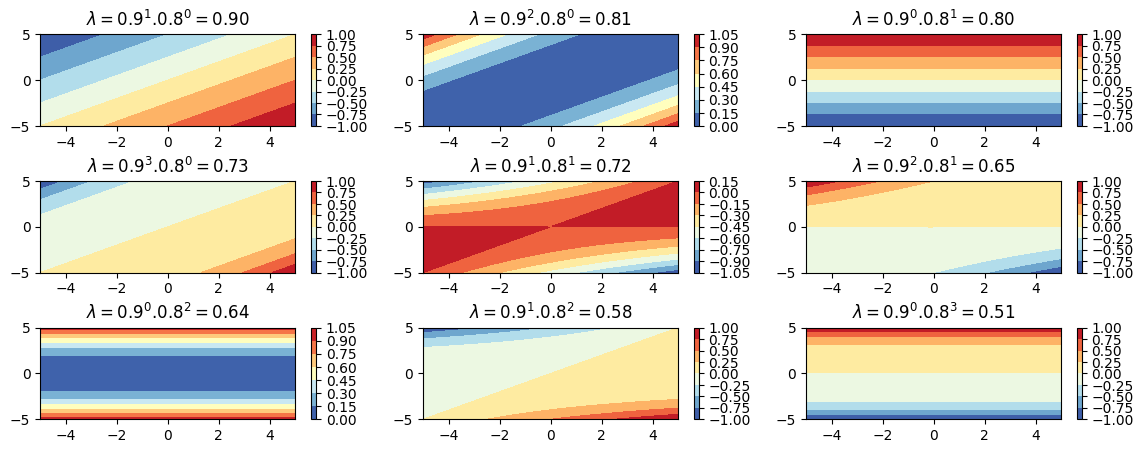

In [591]:
f, ax = plt.subplots(3, 3, figsize=(14, 5))
plt.subplots_adjust(hspace=0.6)

def plot_eigenfunction_contour(m, n, ax):
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    Z = eigfunction_generate(X, Y, m,n)
    Z = Z/np.max(np.abs(Z))

    h = ax.contourf(X, Y, Z, cmap='RdYlBu_r')
    eig = (eigvalue_i)**m * (eigvalue_j) ** n
    eig_str = f"$\lambda = {eigvalue_i}^{m} . {eigvalue_j}^{n} = {eig:0.2f}$"
    
    ax.set_title(eig_str)
    plt.colorbar(h)    
    return ax
    
for i, (m,n) in enumerate(sorted_eig):
    plot_eigenfunction_contour(m=m, n=n,  ax = ax[int(i/3)][i%3])


In [69]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
x_flat = X.flatten()
y_flat = Y.flatten()

# Create a DataFrame from the flattened arrays
df = pd.DataFrame({'x1': x_flat, 'x2': y_flat})
df.columns.name = "feature"

koopman_eigenfunctions_eval = edmd_poly.koopman_eigenfunction(df)
koopman_eigenfunctions_eval

koop_eigfunc0  koop_eigfunc1  koop_eigfunc2  koop_eigfunc3  \
0     -2.501788e-14  -4.297895e-12       7.071068  -2.515573e-12   
1      1.010101e-01   1.020304e-02       7.071068  -1.030610e-03   
2      2.020202e-01   4.081216e-02       7.071068  -8.244881e-03   
3      3.030303e-01   9.182736e-02       7.071068  -2.782647e-02   
4      4.040404e-01   1.632486e-01       7.071068  -6.595905e-02   
...             ...            ...            ...            ...   
9995  -4.040404e-01   1.632486e-01      -7.071068   6.595905e-02   
9996  -3.030303e-01   9.182736e-02      -7.071068   2.782647e-02   
9997  -2.020202e-01   4.081216e-02      -7.071068   8.244881e-03   
9998  -1.010101e-01   1.020304e-02      -7.071068   1.030610e-03   
9999  -1.668783e-13   4.999556e-12      -7.071068   4.694357e-12   

      koop_eigfunc4  koop_eigfunc5  koop_eigfunc6  koop_eigfunc7  \
0     -8.477039e-13   1.044968e-11       43.30127  -2.831814e-12   
1     -1.129327e+00  -1.613242e-01       43.30127  -9.448630e+00   
2     -2.258655e+00  -6.452969e-01       43.30127  -1.889726e+01   
3     -3.387982e+00  -1.451918e+00       43.30127  -2.834589e+01   
4     -4.517309e+00  -2.581188e+00       43.30127  -3.779452e+01   
...             ...            ...            ...            ...   
9995  -4.517309e+00   2.581188e+00       43.30127   3.779452e+01   
9996  -3.387982e+00   1.451918e+00       43.30127   2.834589e+01   
9997  -2.258655e+00   6.452969e-01       43.30127   1.889726e+01   
9998  -1.129327e+00   1.613242e-01       43.30127   9.448630e+00   
9999  -2.455323e-13   1.556531e-11       43.30127   1.614312e-12   

      koop_eigfunc8  
0             250.0  
1             250.0  
2             250.0  
3             250.0  
4             250.0  
...             ...  
9995         -250.0  
9996         -250.0  
9997         -250.0  
9998         -250.0  
9999         -250.0  

[10000 rows x 9 columns]

In [70]:
edmd_poly.koopman_eigenvalues

0    0.900
1    0.810
2    0.800
3    0.729
4    0.720
5    0.648
6    0.640
7    0.576
8    0.512
Name: evals, dtype: float64

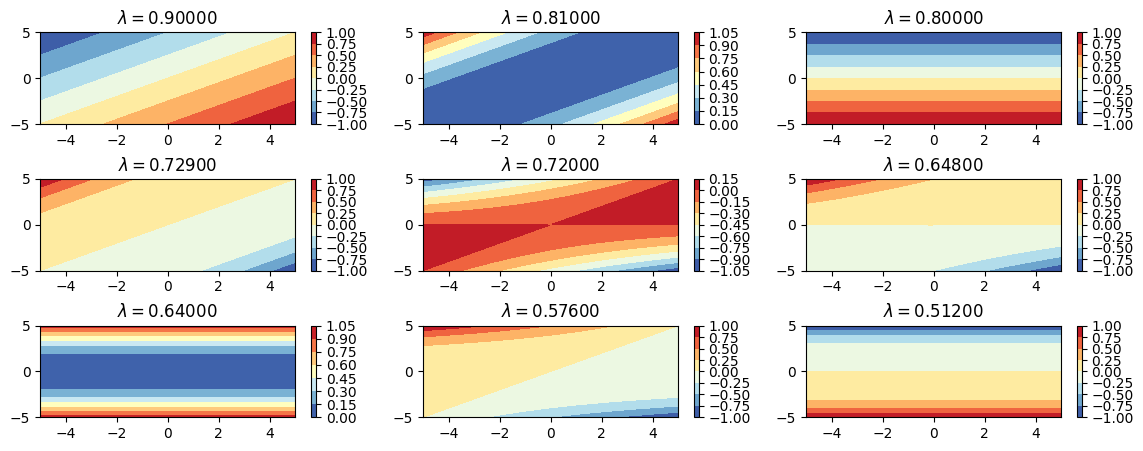

In [71]:
f, ax = plt.subplots(3, 3, figsize=(14, 5))
plt.subplots_adjust(hspace=0.6)

for i in range(koopman_eigenfunctions_eval.shape[1]):
    Z = koopman_eigenfunctions_eval.loc[:,"koop_eigfunc" + str(i)]
    Z = Z/np.max(np.abs(Z))
    h = ax[int(i/3)][i%3].contourf(X, Y, np.array(Z).reshape(100,100), cmap='RdYlBu_r')
    eig = edmd_poly.koopman_eigenvalues[i]

    ax[int(i/3)][i%3].set_title(f"$\lambda = {eig:.5f}$")
    plt.colorbar(h)    


eigenvalues using polynomial EDMD and eigenfunctions seem to agree with the explicit eigenfunctions (although negative sign might be needed for some?)

### now checking if eigenfunctions computed using new vectors agree with some other powers/combinations of explicit eigenfunctions?

#### sanity check $\phi_i(Tx) = \lambda \phi_i(x)$ on detected eigenfunctions

In [32]:
# function to check eigenfunction using the equation $phi_i(Tx) = lambda phi_i(x)$
def check_eigenfunction(tsc_data, eigvalue):
    
    x = tsc_data.initial_states()
    Tx = tsc_data.loc[(slice(None), 1), :]

    
    lhs =  edmd_poly.koopman_eigenfunction(Tx)
    rhs = eigvalue * edmd_poly.koopman_eigenfunction(x)
    
    return lhs, rhs
                        


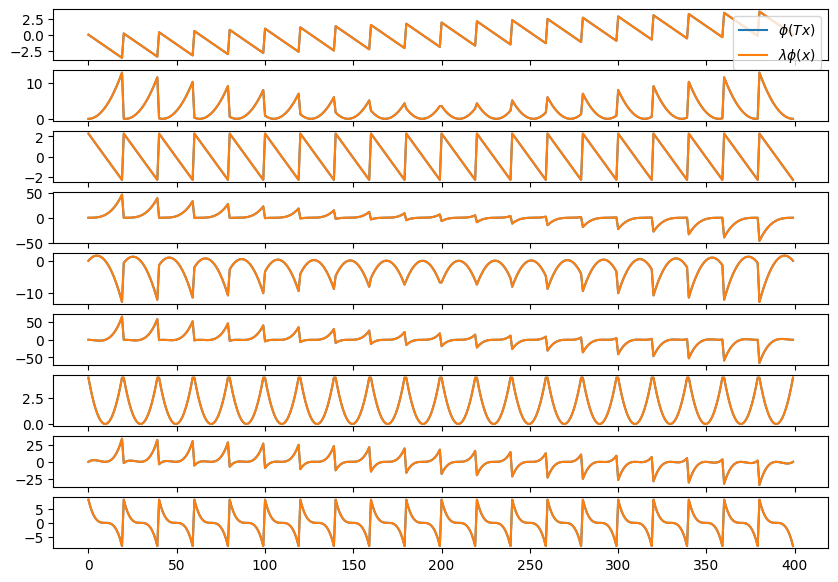

In [33]:
f, ax = plt.subplots(edmd_poly.koopman_eigenvalues.shape[0],1, figsize = (10,7))
for i, eig in enumerate(edmd_poly.koopman_eigenvalues):
    lhs, rhs = check_eigenfunction(tsc_data, eig)
    
    ax[i].plot(lhs.iloc[:,i].to_numpy().real, label="$\phi(Tx)$")
    ax[i].plot(rhs.iloc[:,i].to_numpy().real, label="$\lambda \phi(x)$")

    if i == 0:
        ax[i].legend()

handles, labels = ax[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4)

# Display the plot

plt.show()

In [34]:
from datafold.utils.general import sort_eigenpairs

(9,) (9, 9)
[0.9   0.81  0.8   0.729 0.72  0.648 0.64  0.576 0.512]


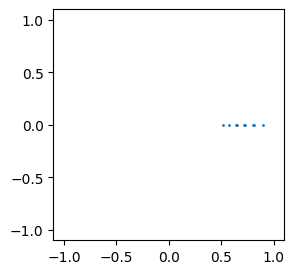

In [114]:
dictionary_eval = edmd_poly.dict_steps[0][1].transform(tsc_data)
dictionary_eval = edmd_poly._attach_id_state(X=tsc_data, X_dict=dictionary_eval) #include id states
koopman_matrix = edmd_poly.dmd_model._compute_koopman_matrix(dictionary_eval)
koopman_eigvals, koopman_eigvecs = sort_eigenpairs(*np.linalg.eig(koopman_matrix))

print(koopman_eigvals.shape, koopman_eigvecs.shape)

xlim = [-1.1, 1.1]
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(koopman_eigvals.real, koopman_eigvals.imag, s=1)
ax.set_xlim(xlim)
ax.set_ylim(xlim)
ax.set_aspect(1)
print(koopman_eigvals)

In [36]:
edmd_poly.koopman_eigenvalues

0    0.900
1    0.810
2    0.800
3    0.729
4    0.720
5    0.648
6    0.640
7    0.576
8    0.512
Name: evals, dtype: float64

In [37]:
edmd_poly._dmd_model.eigenvectors_right_.shape

(9, 9)

In [38]:
koopman_eigvecs.shape

(9, 9)

In [39]:
dictionary_eval.shape, tsc_data.shape

((800, 9), (800, 2))

In [40]:
np.isclose(edmd_poly._dmd_model.eigenvectors_right_, koopman_eigvecs).all()

True

In [41]:
pseudo_eigenfunctions = (np.linalg.pinv(koopman_eigvecs) @ dictionary_eval.to_numpy().T).T
pseudo_eigenfunctions.shape

(800, 9)

In [42]:
np.allclose(edmd_poly.koopman_eigenfunction(tsc_data), 
            (np.linalg.pinv(koopman_eigvecs) @ dictionary_eval.to_numpy().T).T)

True

#### take squares of all eigenvectors and extend

In [43]:
koopman_eigvecs_ext = np.hstack((koopman_eigvecs, koopman_eigvecs ** 3))
koopman_eigvecs_ext.shape

(9, 18)

In [44]:
koopman_eigvals_ext = np.hstack((koopman_eigvals, koopman_eigvals**3))
koopman_eigvals_ext.shape

(18,)

In [45]:
np.linalg.pinv(koopman_eigvecs_ext).shape

(18, 9)

In [48]:
# reconstruct koopman matrix using extended eigenvectors
koopman_matrix_new = koopman_eigvecs_ext @ np.diag(koopman_eigvals_ext) @ np.linalg.pinv(koopman_eigvecs_ext)
koopman_matrix_new.shape

(9, 9)

In [53]:
koopman_eigvals_new, koopman_eigvecs_new = sort_eigenpairs(*np.linalg.eig(koopman_matrix_new))
koopman_eigvecs_new.shape

(9, 9)

In [47]:
pseudo_eigenfunctions_ext = (np.linalg.pinv(koopman_eigvecs_ext) @ dictionary_eval.to_numpy().T).T
pseudo_eigenfunctions_ext.shape

(800, 18)

In [54]:
def check_eigenfunction_ext(eigvalue):
    x = tsc_data.initial_states()
    Tx = tsc_data.loc[(slice(None), 1), :]

    Tx_dictionary_eval = edmd_poly.dict_steps[0][1].transform(Tx)
    Tx_dictionary_eval = edmd_poly._attach_id_state(X=Tx, X_dict=Tx_dictionary_eval) #include id states

    x_dictionary_eval = edmd_poly.dict_steps[0][1].transform(x)
    x_dictionary_eval = edmd_poly._attach_id_state(X=x, X_dict=x_dictionary_eval)

    Tx_pseudo_eigenfunctions_ext = (np.linalg.pinv(koopman_eigvecs_ext) @ Tx_dictionary_eval.to_numpy().T).T

    x_pseudo_eigenfunctions_ext = (np.linalg.pinv(koopman_eigvecs_ext) @ x_dictionary_eval.to_numpy().T).T



    lhs = Tx_pseudo_eigenfunctions_ext
    rhs = eigvalue * x_pseudo_eigenfunctions_ext

    return lhs, rhs

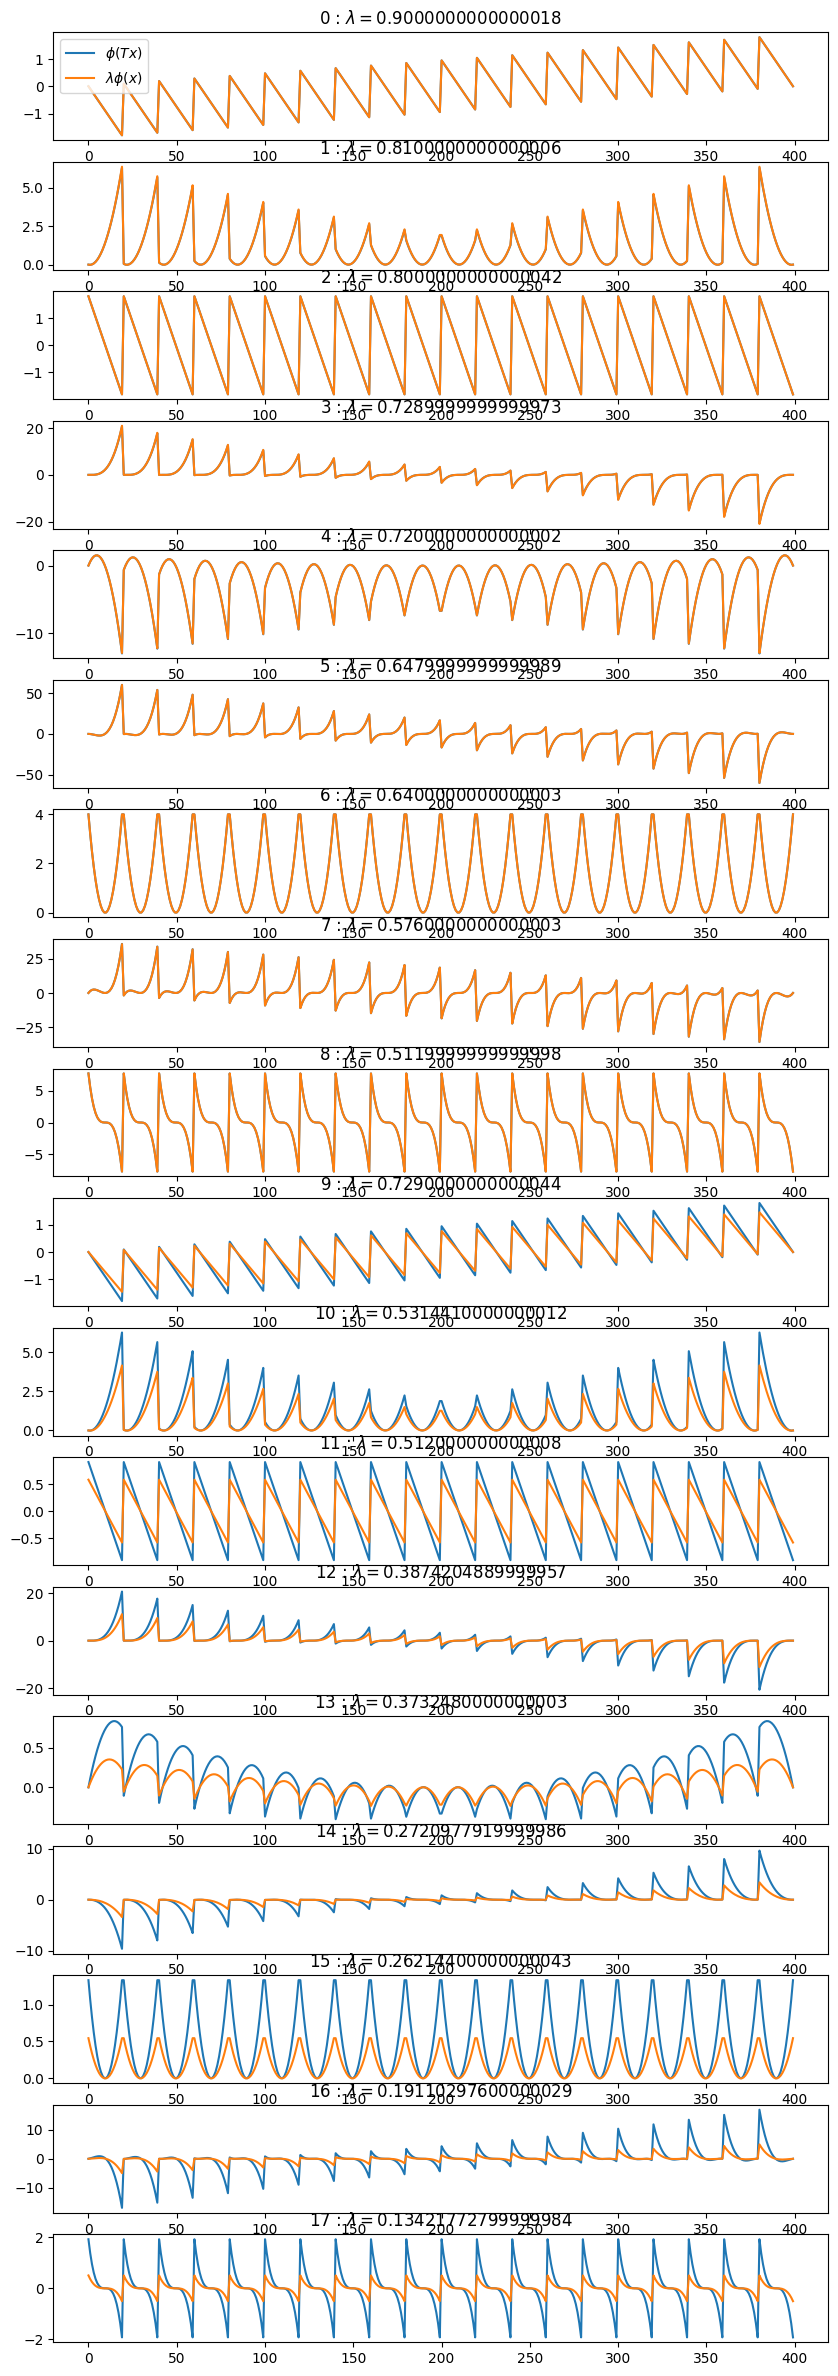

In [55]:
f, ax = plt.subplots(koopman_eigvecs_ext.shape[1], 1, figsize = (10,30))
for i in range(koopman_eigvecs_ext.shape[1]):
    
    if i <= koopman_eigvals.shape[0] - 1:
        eig = koopman_eigvals[i]
    
    if i > koopman_eigvals.shape[0] - 1:
        eig = koopman_eigvals[i-koopman_eigvals.shape[0]] ** 3
#         eig = koopman_eigvals[i-koopman_eigvals.shape[0]]
        
    lhs, rhs = check_eigenfunction_ext(eig)
    
    ax[i].plot(lhs[:,i], label="$\phi(Tx)$")
    ax[i].plot(rhs[:,i], label="$\lambda \phi(x)$")
    ax[i].set_title(f"{i} : $\lambda = {eig}$")

    if i == 0:
        ax[i].legend()

# handles, labels = ax[i].get_legend_handles_labels()
# f.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)

# Display the plot

plt.show()

- some of the new eigenfunctions seem to be eigenfunctions?
- new eigenfunctions also seem to be powers of the eigenfunctions - this is good and came about on its own right?
- first 9 eigenfunctions seem to be perfect eigenfunctions?
- when eig = same eig for the new eigenfunctions then they seem to be eignefunctions

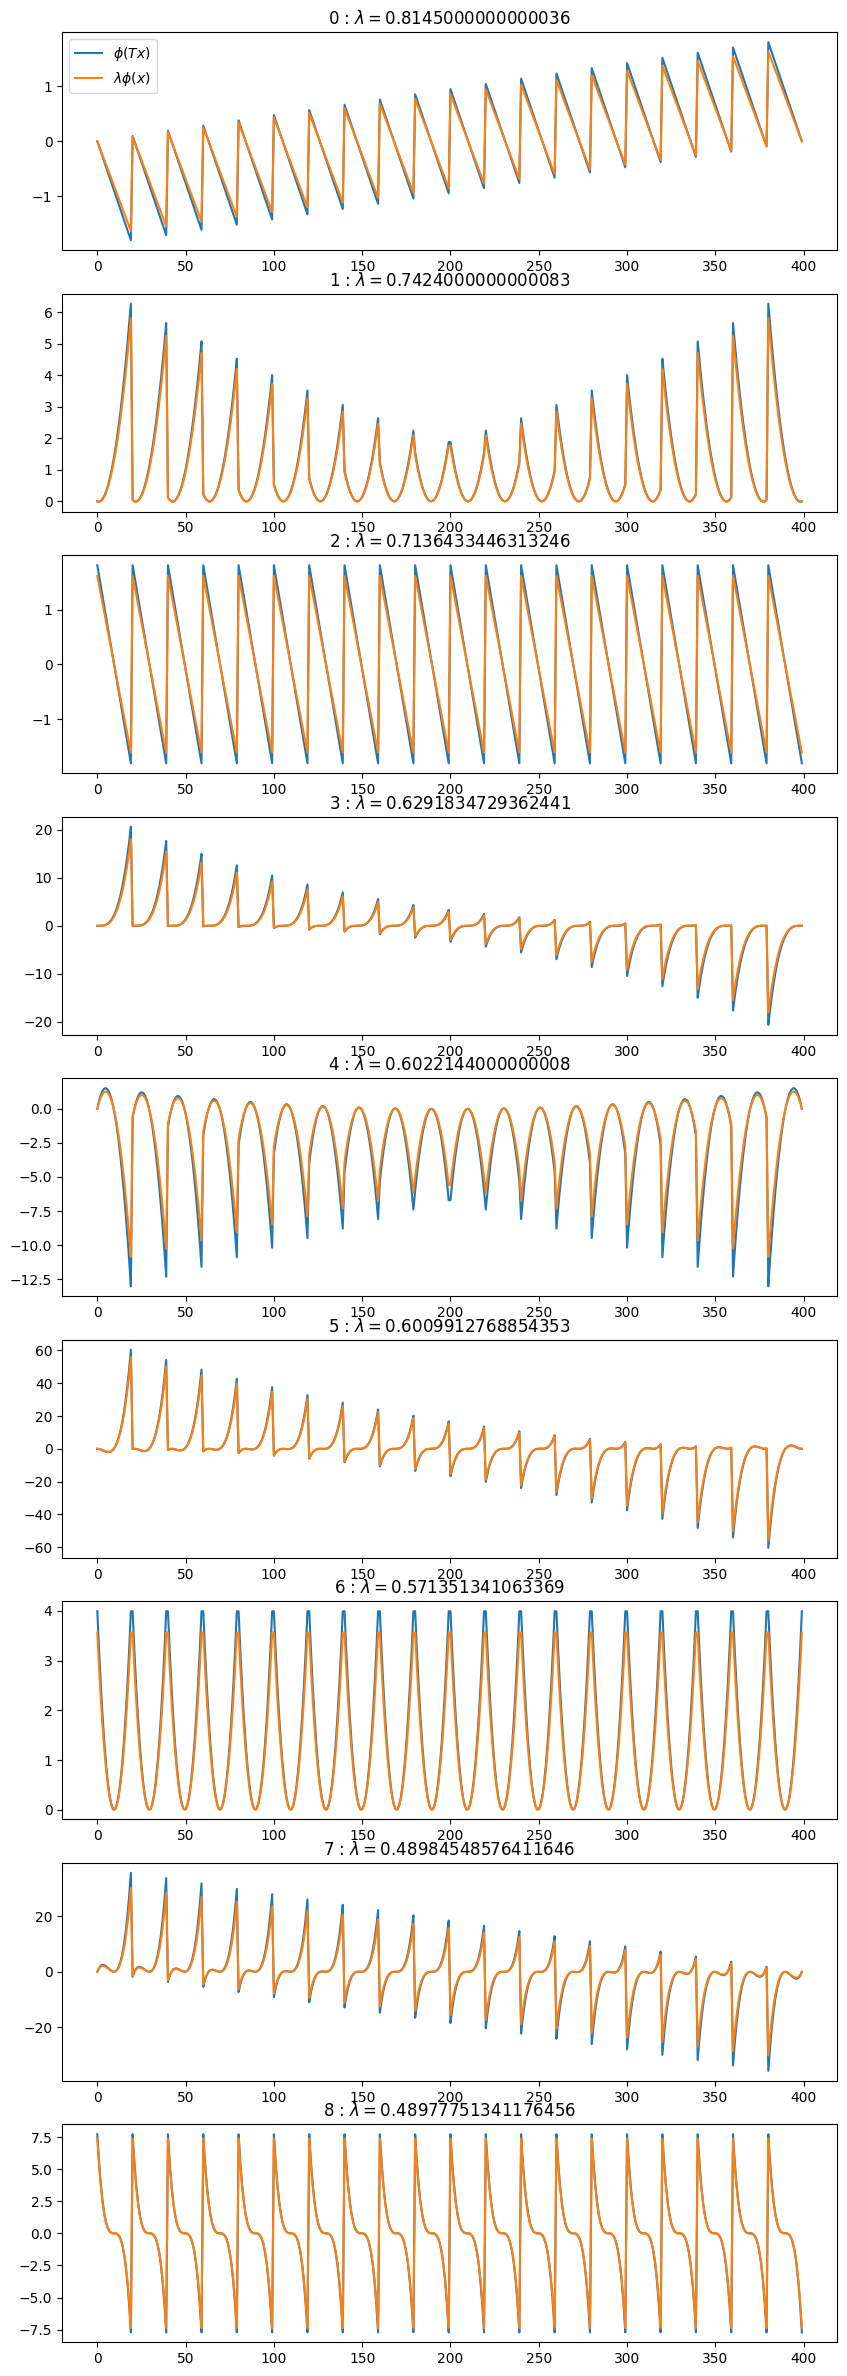

In [56]:
f, ax = plt.subplots(koopman_eigvecs_new.shape[1], 1, figsize = (10,30))
for i in range(koopman_eigvecs_new.shape[1]):
    
    eig = koopman_eigvals_new[i]
    
    lhs, rhs = check_eigenfunction_ext(eig)
    
    ax[i].plot(lhs[:,i], label="$\phi(Tx)$")
    ax[i].plot(rhs[:,i], label="$\lambda \phi(x)$")
    ax[i].set_title(f"{i} : $\lambda = {eig}$")

    if i == 0:
        ax[i].legend()

# handles, labels = ax[i].get_legend_handles_labels()
# f.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)

# Display the plot

plt.show()

In [57]:
# now comparing the new eigenfunctions with the explicit eigenfunctions using heatmaps

In [115]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
x_flat = X.flatten()
y_flat = Y.flatten()

# Create a DataFrame from the flattened arrays
df = pd.DataFrame({'x1': x_flat, 'x2': y_flat})
df.columns.name = "feature"


dictionary_eval_grid = edmd_poly.dict_steps[0][1].transform(df)
dictionary_eval_grid = edmd_poly._attach_id_state(X=df, X_dict=dictionary_eval_grid)

koopman_eigenfunctions_eval = (np.linalg.pinv(koopman_eigvecs_new) @ dictionary_eval_grid.to_numpy().T).T
koopman_eigenfunctions_eval.shape

(10000, 9)

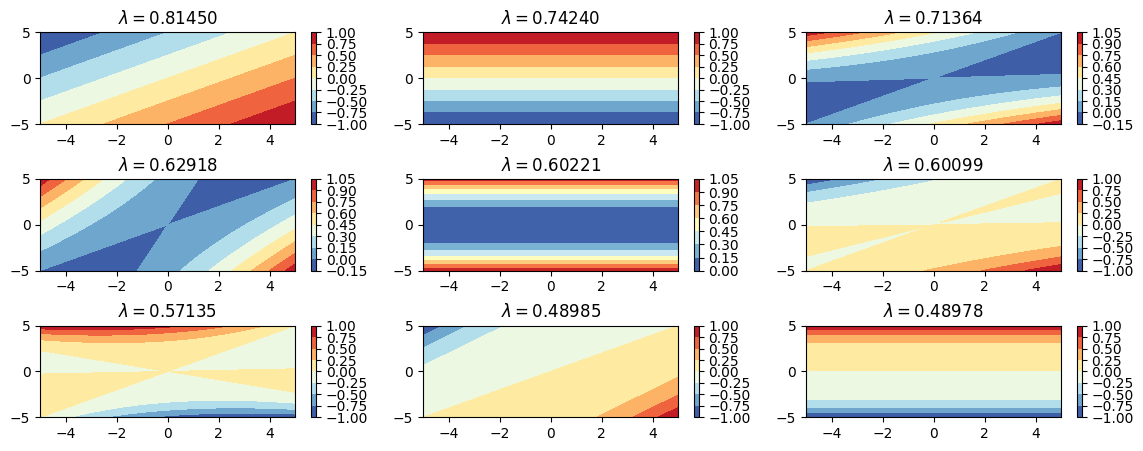

In [116]:
f, ax = plt.subplots(3, 3, figsize=(14, 5))
plt.subplots_adjust(hspace=0.6)

for i in range(koopman_eigenfunctions_eval.shape[1]):
    Z = koopman_eigenfunctions_eval[:, i]
    Z = Z/np.max(np.abs(Z))
    h = ax[int(i/3)][i%3].contourf(X, Y, np.array(Z).reshape(100,100), cmap='RdYlBu_r')
    eig = koopman_eigvals_new[i]

    ax[int(i/3)][i%3].set_title(f"$\lambda = {eig:.5f}$")
    plt.colorbar(h)    



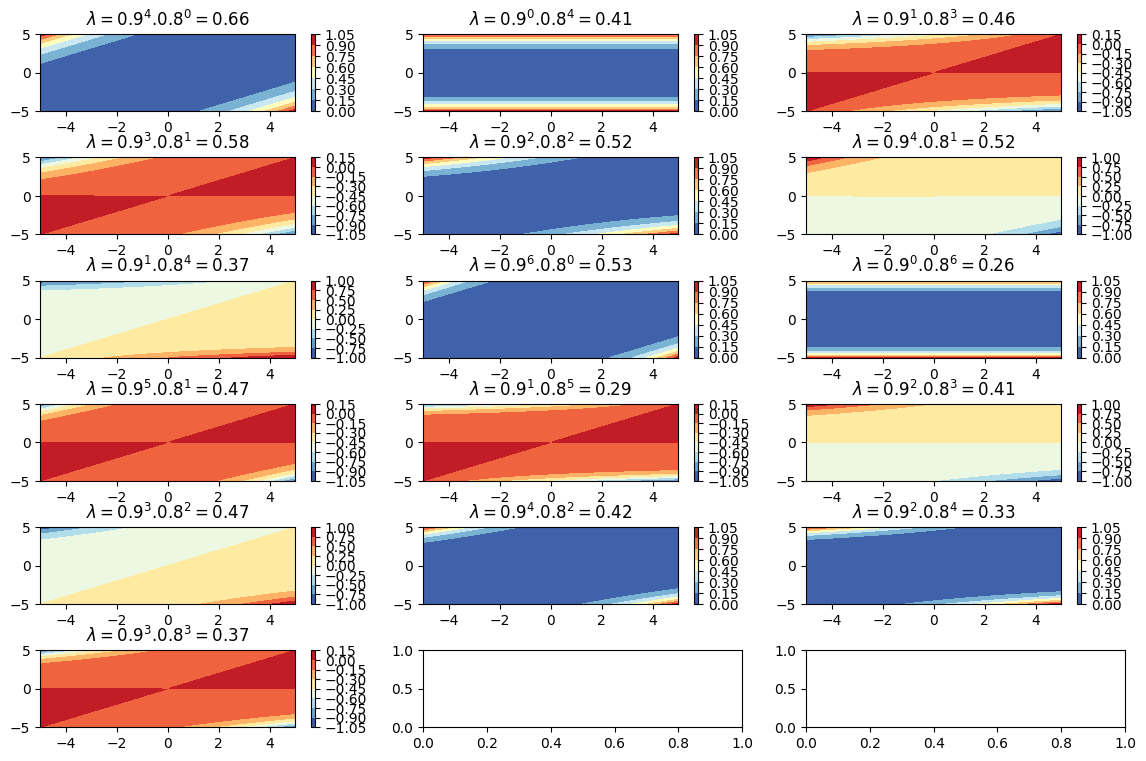

In [117]:
# plot some higher powers of explicit eigenfunctions to compare
f, ax = plt.subplots(6, 3, figsize=(14, 9))
plt.subplots_adjust(hspace=0.6)

sorted_eig = [(4,0), (0,4) , (1,3), (3,1), (2,2), (4,1), (1,4), (6,0), (0,6), (5,1), (1,5), (2,3), (3,2), 
              (4,2), (2,4), (3,3)]
for i, (m,n) in enumerate(sorted_eig):
    plot_eigenfunction_contour(m=m, n=n,  ax = ax[int(i/3)][i%3])

do not see any of the eigenfunctions from extended koopman matrix related to the higher power eigenfunctions

### finding eigenfunctions using left eigenvectors

In [687]:
left_koopman_eigvals, left_koopman_eignvectors = sort_eigenpairs(*np.linalg.eig(koopman_matrix.T))
left_koopman_eignvectors.shape

(9, 9)

In [688]:
left_koopman_eignvectors[:,i].reshape(left_koopman_eignvectors.shape[0]).shape

(9,)

In [689]:
# check if cols are left eigenvectors
for i in range(left_koopman_eignvectors.shape[1]):
    reshape_vec = left_koopman_eignvectors[:,i].reshape(left_koopman_eignvectors.shape[0])
    print(np.allclose(reshape_vec @koopman_matrix, 
                      left_koopman_eigvals[i] * reshape_vec))

True
True
True
True
True
True
True
True
True


In [690]:
left_koopman_eigvals

array([0.9  , 0.81 , 0.8  , 0.729, 0.72 , 0.648, 0.64 , 0.576, 0.512])

In [691]:
(dictionary_eval.to_numpy() @ left_koopman_eignvectors).shape

(800, 9)

In [692]:
np.isclose(dictionary_eval.to_numpy() @ left_koopman_eignvectors, edmd_poly.koopman_eigenfunction(tsc_data))

array([[ True,  True, False, ..., False,  True, False],
       [ True,  True, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [ True,  True, False, ..., False,  True, False],
       [ True,  True, False, ..., False,  True, False]])

In [693]:
edmd_poly.koopman_eigenfunction(tsc_data)

feature   koop_eigfunc0  koop_eigfunc1  koop_eigfunc2  koop_eigfunc3  \
ID  time                                                               
0   0      3.753726e-14  -2.096545e-12       2.828427  -3.735394e-13   
    1      3.406318e-14  -1.708411e-12       2.262742  -2.752624e-13   
1   0     -2.105263e-01   4.432133e-02       2.530698   9.330806e-03   
    1     -1.894737e-01   3.590028e-02       2.024558   6.802158e-03   
2   0     -4.210526e-01   1.772853e-01       2.232969   7.464645e-02   
...                 ...            ...            ...            ...   
397 1      3.789474e-01   1.436011e-01      -1.786375  -5.441726e-02   
398 0      2.105263e-01   4.432133e-02      -2.530698  -9.330806e-03   
    1      1.894737e-01   3.590028e-02      -2.024558  -6.802158e-03   
399 0     -6.754721e-14   2.220890e-12      -2.828427   7.286788e-13   
    1     -5.327732e-14   1.783018e-12      -2.262742   5.043059e-13   

feature   koop_eigfunc4  koop_eigfunc5  koop_eigfunc6  koop_eigfunc7  \
ID  time                                                               
0   0     -2.296883e-13   1.819405e-12       6.928203  -2.563894e-13   
    1     -1.673029e-13   1.153693e-12       4.434050  -1.600010e-13   
1   0      8.423968e-01  -2.508061e-01       5.546401   2.522441e+00   
    1      6.065257e-01  -1.625224e-01       3.549697   1.452926e+00   
2   0      1.486583e+00  -8.851980e-01       4.318132   3.927677e+00   
...                 ...            ...            ...            ...   
397 1      1.070339e+00   5.736083e-01       2.763605  -2.262342e+00   
398 0      8.423968e-01   2.508061e-01       5.546401  -2.522441e+00   
    1      6.065257e-01   1.625224e-01       3.549697  -1.452926e+00   
399 0      4.177920e-14   2.391769e-12       6.928203   8.278863e-14   
    1      5.230447e-14   1.527710e-12       4.434050   3.614296e-14   

feature   koop_eigfunc8  
ID  time                 
0   0         16.000000  
    1          8.192000  
1   0         11.460563  
    1          5.867808  
2   0          7.872868  
...                 ...  
397 1         -4.030908  
398 0        -11.460563  
    1         -5.867808  
399 0        -16.000000  
    1         -8.192000  

[800 rows x 9 columns]

In [694]:
def check_eigenfunction_left(eigvalue):
    x = tsc_data.initial_states()
    Tx = tsc_data.loc[(slice(None), 1), :]

    Tx_dictionary_eval = edmd_poly.dict_steps[0][1].transform(Tx)
    Tx_dictionary_eval = edmd_poly._attach_id_state(X=Tx, X_dict=Tx_dictionary_eval) #include id states

    x_dictionary_eval = edmd_poly.dict_steps[0][1].transform(x)
    x_dictionary_eval = edmd_poly._attach_id_state(X=x, X_dict=x_dictionary_eval)

    Tx_pseudo_eigenfunctions_ext = Tx_dictionary_eval.to_numpy() @ left_koopman_eignvectors

    x_pseudo_eigenfunctions_ext = x_dictionary_eval.to_numpy() @ left_koopman_eignvectors


    lhs = Tx_pseudo_eigenfunctions_ext
    rhs = eigvalue * x_pseudo_eigenfunctions_ext

    return lhs, rhs

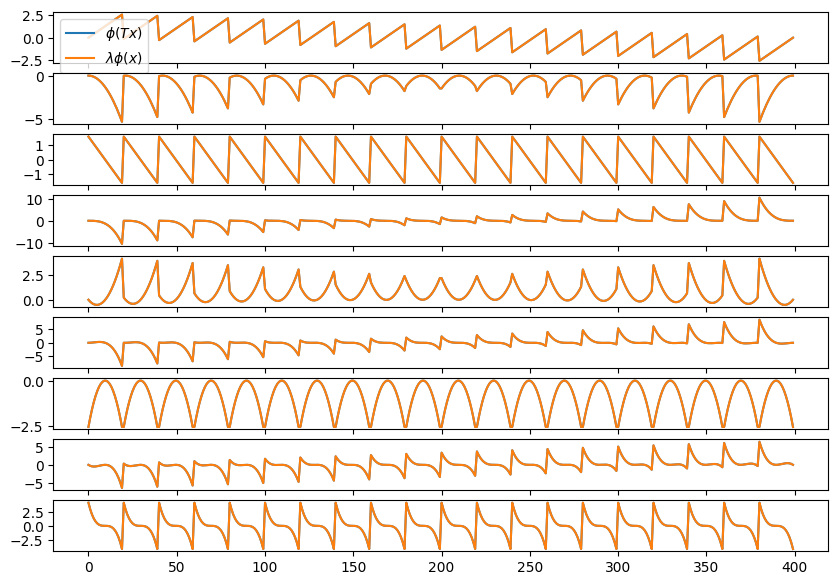

In [695]:
f, ax = plt.subplots(left_koopman_eigvals.shape[0],1, figsize = (10,7))
for i, eig in enumerate(left_koopman_eigvals):
    lhs, rhs = check_eigenfunction_left(eig)
    
    ax[i].plot(lhs[:,i].real, label="$\phi(Tx)$")
    ax[i].plot(rhs[:,i].real, label="$\lambda \phi(x)$")

    if i == 0:
        ax[i].legend()

handles, labels = ax[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4)

# Display the plot

plt.show()

In [696]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
x_flat = X.flatten()
y_flat = Y.flatten()

# Create a DataFrame from the flattened arrays
df = pd.DataFrame({'x1': x_flat, 'x2': y_flat})
df.columns.name = "feature"


dictionary_eval_grid = edmd_poly.dict_steps[0][1].transform(df)
dictionary_eval_grid = edmd_poly._attach_id_state(X=df, X_dict=dictionary_eval_grid)

koopman_eigenfunctions_eval = dictionary_eval_grid.to_numpy() @ left_koopman_eignvectors
koopman_eigenfunctions_eval.shape

(10000, 9)

#### check if eigenfunctions are same as explicit eigenfunctions

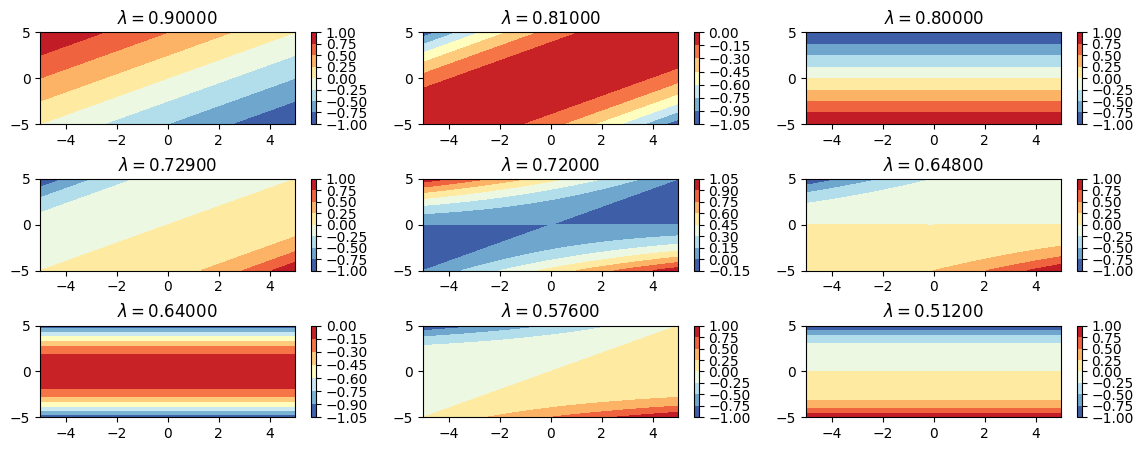

In [697]:
f, ax = plt.subplots(3, 3, figsize=(14, 5))
plt.subplots_adjust(hspace=0.6)

for i in range(koopman_eigenfunctions_eval.shape[1]):
    
    Z = koopman_eigenfunctions_eval[:, i]
    Z = Z/np.max(np.abs(Z))
    
    h = ax[int(i/3)][i%3].contourf(X, Y, np.array(Z).reshape(100,100), cmap='RdYlBu_r')
    eig = left_koopman_eigvals[i]

    ax[int(i/3)][i%3].set_title(f"$\lambda = {eig:.5f}$")
    plt.colorbar(h)    




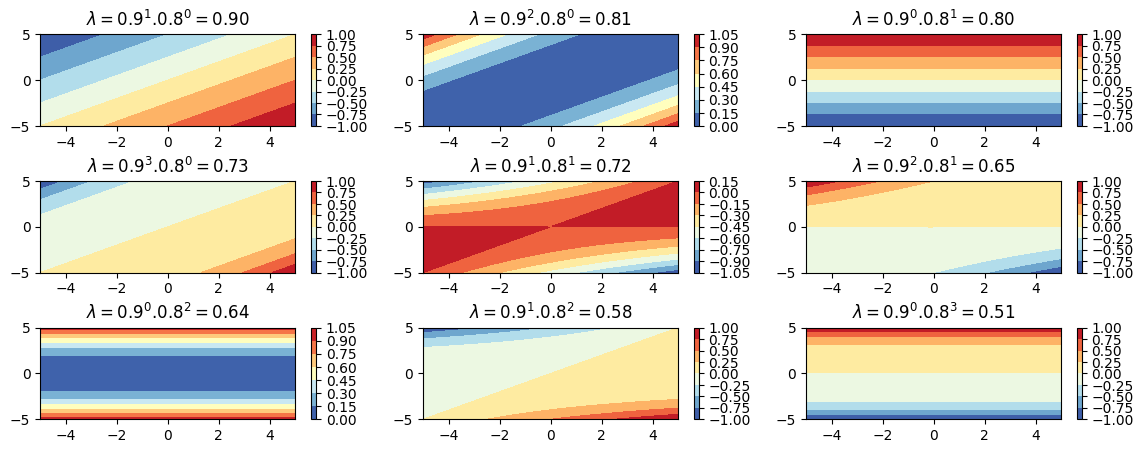

In [698]:
f, ax = plt.subplots(3, 3, figsize=(14, 5))
plt.subplots_adjust(hspace=0.6)
    
for i, (m,n) in enumerate(sorted_eig):
    
    plot_eigenfunction_contour(m=m, n=n,  ax = ax[int(i/3)][i%3])

In [699]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
x_flat = X.flatten()
y_flat = Y.flatten()

df = pd.DataFrame({'x1': x_flat, 'x2': y_flat})
df.columns.name = "feature"

dictionary_eval_grid = edmd_poly.dict_steps[0][1].transform(df)
dictionary_eval_grid = edmd_poly._attach_id_state(X=df, X_dict=dictionary_eval_grid)
dictionary_eval_grid.shape

(10000, 9)

In [700]:
Z_l = (dictionary_eval_grid @ left_koopman_eignvectors[:,2])**2
Z_l = Z_l/np.max(np.abs(Z_l))

Z_r = (dictionary_eval_grid @ left_koopman_eignvectors[:,6])
Z_r = Z_r/np.max(np.abs(Z_r))
Z_r

Z_e = eigfunction_generate(x_flat,y_flat, m=0, n=2)
Z_e = Z_e/np.max(np.abs(Z_e))
Z_e

np.allclose(np.abs(Z_l), np.abs(Z_r)), np.allclose(np.abs(Z_l), np.abs(Z_e)), np.allclose(np.abs(Z_r), np.abs(Z_e))

(True, True, True)

#### check integer powers of two simple eigenfunctions

In [701]:
left_koopman_eigvals

array([0.9  , 0.81 , 0.8  , 0.729, 0.72 , 0.648, 0.64 , 0.576, 0.512])

0th col of left_koopman_eigenvectors corresponds to eigenvalue 0.9 and explicit eigenfunction w_i(x,y) = (x-y)/sqrt(2)

2nd col of left_koopman_eigenvectors corresponds to eigenvalue 0.8 and explicit eigenfunction w_j(x,y) = y 

4 the col of left_koopman_eigenvectors corresponds to eigenvalue 0.72 and explicit eigenfunction w_i . w_j

In [702]:
# Test for first explicit eigenfunction
for i_pow in range(2,7):
    print("power: ", i_pow)
    Z_l = (dictionary_eval_grid @ left_koopman_eignvectors[:,0])**i_pow
    Z_l = Z_l/np.max(np.abs(Z_l))
    
    Z_e = eigfunction_generate(x_flat,y_flat, m=i_pow, n=0)
    Z_e = Z_e/np.max(np.abs(Z_e))

    print("new eigenfunction is equal to explicit eigenvalue_squared")
    print(np.allclose(np.abs(Z_e), np.abs(Z_l)))


power:  2
new eigenfunction is equal to explicit eigenvalue_squared
True
power:  3
new eigenfunction is equal to explicit eigenvalue_squared
True
power:  4
new eigenfunction is equal to explicit eigenvalue_squared
True
power:  5
new eigenfunction is equal to explicit eigenvalue_squared
True
power:  6
new eigenfunction is equal to explicit eigenvalue_squared
True


In [703]:
# Test for second explicit eigenfunction
for i_pow in range(2,7):
    print("power: ", i_pow)
    Z_l = (dictionary_eval_grid @ left_koopman_eignvectors[:,2])**i_pow
    Z_l = Z_l/np.max(np.abs(Z_l))
    
    Z_e = eigfunction_generate(x_flat,y_flat, m=0, n=i_pow)
    Z_e = Z_e/np.max(np.abs(Z_e))

    print("new eigenfunction is equal to explicit eigenvalue_squared")
    print(np.allclose(np.abs(Z_e), np.abs(Z_l)))



power:  2
new eigenfunction is equal to explicit eigenvalue_squared
True
power:  3
new eigenfunction is equal to explicit eigenvalue_squared
True
power:  4
new eigenfunction is equal to explicit eigenvalue_squared
True
power:  5
new eigenfunction is equal to explicit eigenvalue_squared
True
power:  6
new eigenfunction is equal to explicit eigenvalue_squared
True


In [704]:
# test for multiplication powers

for i_pow in range(1,7):
    print("power: ", i_pow)
    Z_l = (dictionary_eval_grid @ left_koopman_eignvectors[:,4])**i_pow
    Z_l = Z_l/np.max(np.abs(Z_l))
    
    Z_e = eigfunction_generate(x_flat,y_flat, m=i_pow, n=i_pow)
    Z_e = Z_e/np.max(np.abs(Z_e))

    print("new eigenfunction is equal to explicit eigenvalue_squared")
    print(np.allclose(np.abs(Z_e), np.abs(Z_l)))

power:  1
new eigenfunction is equal to explicit eigenvalue_squared
True
power:  2
new eigenfunction is equal to explicit eigenvalue_squared
True
power:  3
new eigenfunction is equal to explicit eigenvalue_squared
True
power:  4
new eigenfunction is equal to explicit eigenvalue_squared
True
power:  5
new eigenfunction is equal to explicit eigenvalue_squared
True
power:  6
new eigenfunction is equal to explicit eigenvalue_squared
True


In [705]:
# test for multiplication powers

for i_pow in range(2,7):
    print("power: ", i_pow)
    Z_l = (dictionary_eval_grid @ left_koopman_eignvectors[:,5])**i_pow
    Z_l = Z_l/np.max(np.abs(Z_l))
    
    Z_e = eigfunction_generate(x_flat,y_flat, m= 2*(i_pow), n=i_pow)
    Z_e = Z_e/np.max(np.abs(Z_e))

    print("new eigenfunction is equal to explicit eigenvalue_squared")
    print(np.allclose(np.abs(Z_e), np.abs(Z_l)))

power:  2
new eigenfunction is equal to explicit eigenvalue_squared
True
power:  3
new eigenfunction is equal to explicit eigenvalue_squared
True
power:  4
new eigenfunction is equal to explicit eigenvalue_squared
True
power:  5
new eigenfunction is equal to explicit eigenvalue_squared
True
power:  6
new eigenfunction is equal to explicit eigenvalue_squared
True


In [706]:
# test for pairwise multiples

v_1_phi = (dictionary_eval_grid @ left_koopman_eignvectors[:,0])
v_2_phi = (dictionary_eval_grid @ left_koopman_eignvectors[:,2])

for i in range(0,7):
    for j in range(0,7):
        
        if i+j==0:
            continue
        
        if i==0:
            Z_l = (v_2_phi ** j)
        elif j==0:
            Z_l = (v_1_phi ** i)
        else:
            Z_l = (v_1_phi ** i) * (v_2_phi ** j)
        
        
        Z_l = Z_l/np.max(np.abs(Z_l))

        Z_e = eigfunction_generate(x_flat,y_flat, m=i, n=j)
        Z_e = Z_e/np.max(np.abs(Z_e))
        
        print(f"power of v_1_phi: {i}, power of v_2_phi: {j}")
        print("is equal to same power of explicit eigenfunction: ", np.allclose(np.abs(Z_l), np.abs(Z_e)))
        print("\n")

power of v_1_phi: 0, power of v_2_phi: 1
is equal to same power of explicit eigenfunction:  True


power of v_1_phi: 0, power of v_2_phi: 2
is equal to same power of explicit eigenfunction:  True


power of v_1_phi: 0, power of v_2_phi: 3
is equal to same power of explicit eigenfunction:  True


power of v_1_phi: 0, power of v_2_phi: 4
is equal to same power of explicit eigenfunction:  True


power of v_1_phi: 0, power of v_2_phi: 5
is equal to same power of explicit eigenfunction:  True


power of v_1_phi: 0, power of v_2_phi: 6
is equal to same power of explicit eigenfunction:  True


power of v_1_phi: 1, power of v_2_phi: 0
is equal to same power of explicit eigenfunction:  True


power of v_1_phi: 1, power of v_2_phi: 1
is equal to same power of explicit eigenfunction:  True


power of v_1_phi: 1, power of v_2_phi: 2
is equal to same power of explicit eigenfunction:  True


power of v_1_phi: 1, power of v_2_phi: 3
is equal to same power of explicit eigenfunction:  True


power of v

#### plot the above findings

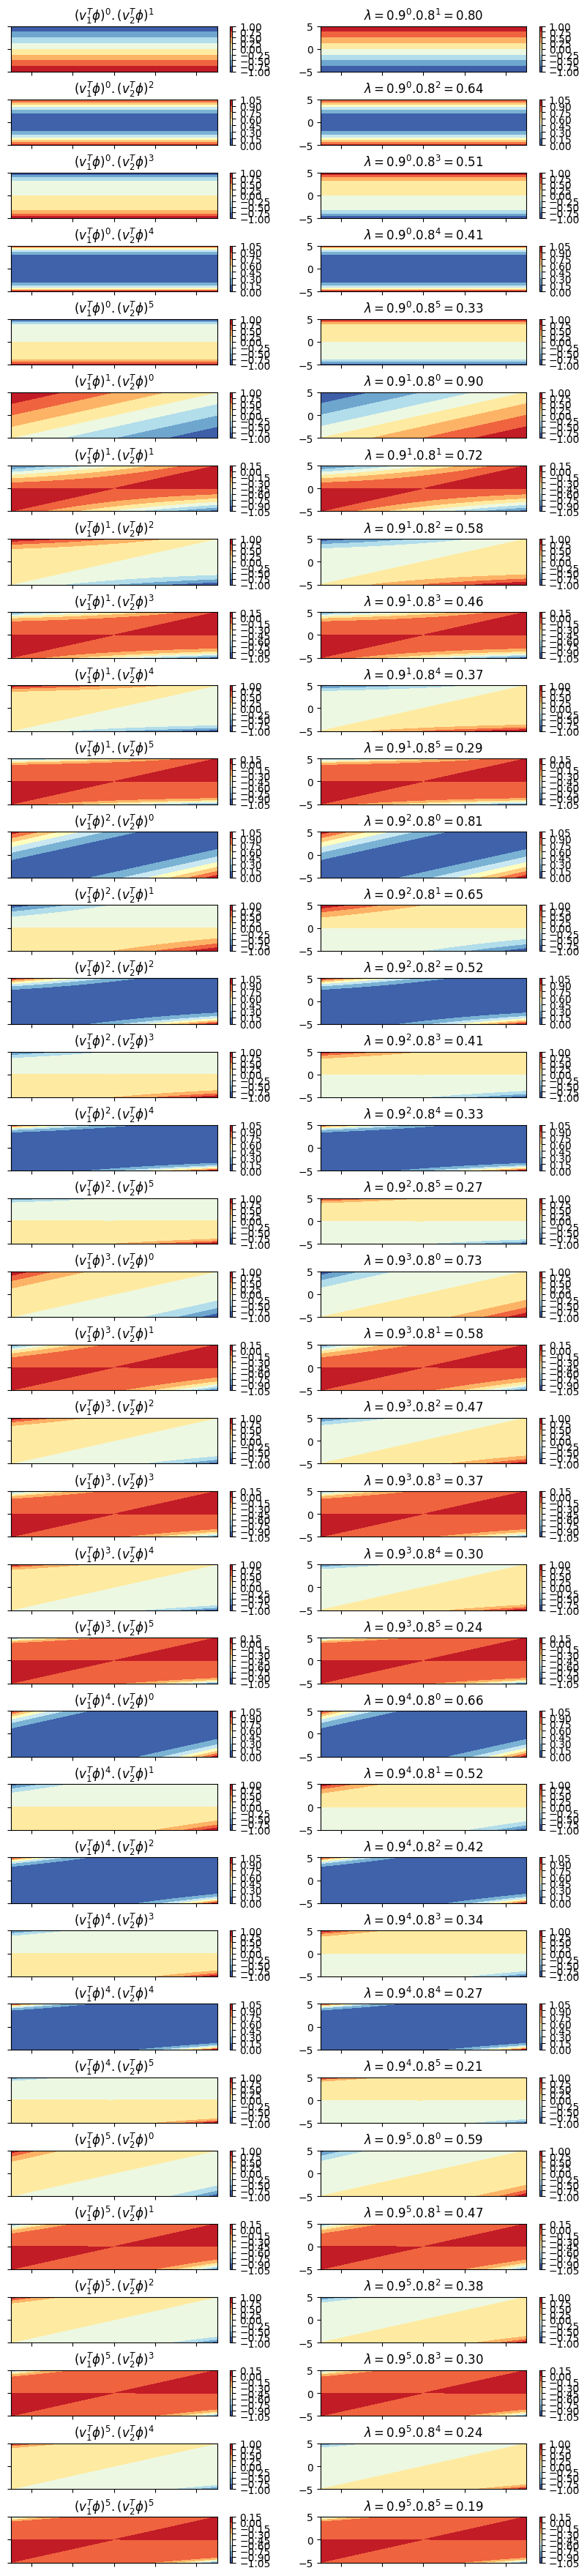

In [707]:
f, ax = plt.subplots(6*6-1, 2, figsize=(10,45))
plt.subplots_adjust(hspace=0.6)


v_1_phi = (dictionary_eval_grid @ left_koopman_eignvectors[:,0])
v_2_phi = (dictionary_eval_grid @ left_koopman_eignvectors[:,2])


c = 0
for i in range(0,6):
    for j in range(0,6):
         
        if i+j==0:
            continue
        
        if i==0:
            Z_l = (v_2_phi ** j)
        elif j==0:
            Z_l = (v_1_phi ** i)
        else:
            Z_l = (v_1_phi ** i) * (v_2_phi ** j)
        
        Z_l = Z_l/np.max(np.abs(Z_l))

        h = ax[c][0].contourf(X, Y, np.array(Z_l).reshape(100,100), cmap='RdYlBu_r')
#         eig = koopman_eigvals_new[i]
        ax[c][0].set_title(f"$(v_1^T \phi)^{i} . (v_2^T \phi)^{j} $")
        ax[c][0].set_xticklabels([])
        ax[c][0].set_yticklabels([])

        plt.colorbar(h) 
        
        ax_ = plot_eigenfunction_contour(m=i, n=j,  ax = ax[c][1])
        ax_.set_xticklabels([])
        ax_.set_xticklabels([])
        
        c +=1
        
#         print(f"power of v_1_phi: {i}, power of v_2_phi: {j}")
#         print("is equal to same power of explicit eigenfunction: ", np.allclose(np.abs(Z_l), np.abs(Z_e)))
#         print("\n")
plt.show()

###  Observables as linear combinaiton of eigenfunctions

In [147]:
edmd_poly.koopman_modes

evec0         evec1     evec2         evec3         evec4  \
feature                                                                     
x1       1.000000e+00  5.544319e-14 -0.707107  1.809401e-16 -1.144326e-15   
x2       1.211570e-17  4.538460e-14 -0.707107  5.283028e-15 -6.222589e-15   

                evec5         evec6         evec7         evec8  
feature                                                          
x1       1.667219e-15 -1.237168e-15 -1.660252e-15 -1.103164e-15  
x2      -9.466187e-17 -3.429784e-15 -1.205631e-15 -1.400204e-15

In [155]:
edmd_poly.koopman_modes @ edmd_poly.koopman_eigenfunction(tsc_data).to_numpy().T

0    1         2         3         4         5         6         7    \
feature                                                                         
x1      -2.0 -1.6 -2.000000 -1.621053 -2.000000 -1.642105 -2.000000 -1.663158   
x2      -2.0 -1.6 -1.789474 -1.431579 -1.578947 -1.263158 -1.368421 -1.094737   

              8         9    ...       790       791       792       793  \
feature                      ...                                           
x1      -2.000000 -1.684211  ...  2.000000  1.684211  2.000000  1.663158   
x2      -1.157895 -0.926316  ...  1.157895  0.926316  1.368421  1.094737   

              794       795       796       797  798  799  
feature                                                    
x1       2.000000  1.642105  2.000000  1.621053  2.0  1.6  
x2       1.578947  1.263158  1.789474  1.431579  2.0  1.6  

[2 rows x 800 columns]

# - -  - - - - - -- - - -- - - - - --END  - - - - - -- - - - - - - #

In [ ]:
# Now we extract the Koopman matrix of the DMD from before and see if
# eigenvectors and their powers are also close to eigenvectors again.
dictionary_eval = edmd_rbf.dict_steps[0][1].transform(tsc_data)
koopman_matrix = edmd_rbf.dmd_model._compute_koopman_matrix(dictionary_eval)
koopman_eigvals, koopman_eigvecs = np.linalg.eig(koopman_matrix)

print(koopman_eigvals.shape, koopman_eigvecs.shape)

xlim = [-1.1, 1.1]
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(koopman_eigvals.real, koopman_eigvals.imag, s=1)
ax.set_xlim(xlim)
ax.set_ylim(xlim)
ax.set_aspect(1)

In [ ]:
def rayleigh_quotient(matrix, vector):
    return (vector.T@matrix@vector)/(vector.T@vector)

In [ ]:
?np.median

In [ ]:
def check_is_eigenvector(matrix, vector, epsilon=1e-1, verbose=False):
    """
    Check if a given vector is an eigenvector of the given matrix - at least, approximatly.
    """
    # done by checking if a 
    vector = vector / np.linalg.norm(vector, keepdims=True)
    v1 = matrix @ vector
    idx_nonzer = np.abs(vector) > 1e-2 # take only those indexes for finding the eigen value where value of component > 1e-2
    approx_eigenvalue = v1[idx_nonzer] / vector[idx_nonzer]
    if verbose:
        print("#nonzero:", np.sum(idx_nonzer))
    # checks if standard deviation in approx eigenvalue from all components is small     
    return np.std(np.abs(approx_eigenvalue)) < epsilon, approx_eigenvalue, np.median(approx_eigenvalue)

def check_exponent_eigenvectors(koopman_matrix, koopman_eigvecs, koopman_eigvals, exponent = 2):
    print("is eigenvector?", check_is_eigenvector(koopman_matrix, koopman_eigvecs[:, 0])[0]) # should be ok
    is_eigenvector = []
    computed_eigenvals = []

    # get which eigenvectors have their squares as eigenvectors
    for k in range(koopman_eigvecs.shape[1]):
        is_eigvec, eig_list, median_eig = check_is_eigenvector(koopman_matrix, koopman_eigvecs[:,k]**exponent)
        is_eigenvector.append(is_eigvec)
        if is_eigvec:
            computed_eigenvals.append(median_eig)

    print("No. of powers that are eigenvectors: ", sum(is_eigenvector))
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    ax.scatter(koopman_eigvals[~np.array(is_eigenvector)].real, koopman_eigvals[~np.array(is_eigenvector)].imag, s=3, 
               c="blue",  label="power not eigen")
    ax.scatter(koopman_eigvals[is_eigenvector].real, koopman_eigvals[is_eigenvector].imag, s=3, c="yellow", 
               label="power is eigen")
    ax.set_xlim(xlim)
    ax.set_ylim(xlim)
    ax.set_aspect(1)

    ax.scatter((koopman_eigvals[is_eigenvector]**2).real, (koopman_eigvals[is_eigenvector]**exponent).imag, s=4, c='red', 
               label="powered eigenvalues for\n detected eigenvectors")
    # ax.scatter((koopman_eigvals[is_eigenvector]**3).real, (koopman_eigvals[is_eigenvector]**3).imag, s=4, c='green')
    ax.set_xlim(xlim)
    ax.set_ylim(xlim)
    ax.set_aspect(1)
    ax.legend()

    #   eigvalue histogram for first detected eigenvector  
    fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.set_title("eigen value histogram for first detected eigenvector")
    _, evals, median_evals = check_is_eigenvector(koopman_matrix, koopman_eigvecs[:, is_eigenvector][:,0]**exponent, verbose=True)
    ax.hist(np.abs(evals));
    ax.set_xlim([-1, 3]);
    
    
    # compare approximated eigenvalue for detected eigenvectors with eigenvalue squared
    print("difference between approximated eigenvalue and powered eigenvalue:")    
    for c, e in zip(computed_eigenvals, np.where(is_eigenvector)[0]):
        print("approximated eigenvalue: ",c)
        print("rayleigh quotient: ", rayleigh_quotient(koopman_matrix, koopman_eigvecs[:, e]**exponent))
        print("powered eigenvalue", koopman_eigvals[e]**exponent)
        print("-----")
        


#### Check squared eigen vectors

is eigenvector? True
No. of powers that are eigenvectors:  1
#nonzero: 84
difference between approximated eigenvalue and powered eigenvalue:
approximated eigenvalue:  (0.8895816052914598+0j)
rayleigh quotient:  (0.905093671728677+0j)
powered eigenvalue (0.7750121696218013+0j)
-----


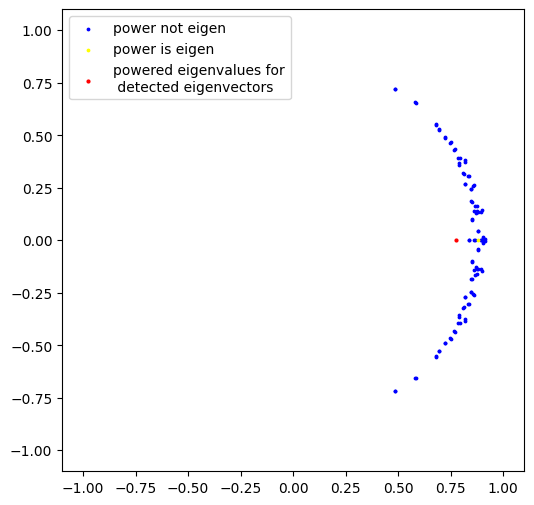

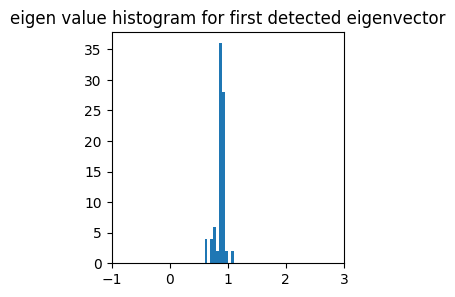

In [64]:
check_exponent_eigenvectors(koopman_matrix, koopman_eigvecs, koopman_eigvals, exponent=2)

#### check cubed eigenvectors

is eigenvector? True
No. of powers that are eigenvectors:  0


IndexError: index 0 is out of bounds for axis 1 with size 0

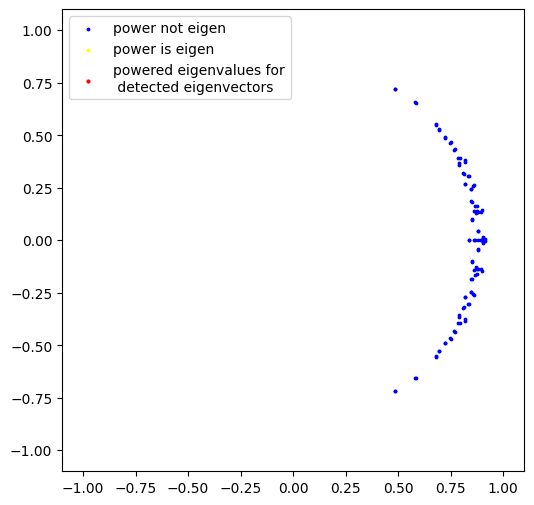

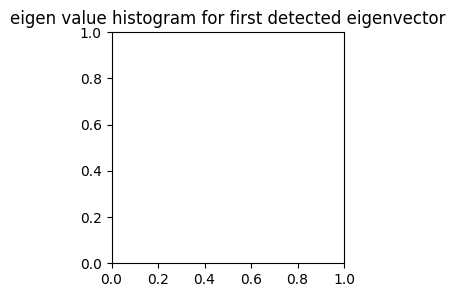

In [65]:
check_exponent_eigenvectors(koopman_matrix, koopman_eigvecs, koopman_eigvals, exponent=3)

is eigenvector? True
No. of powers that are eigenvectors:  0


IndexError: index 0 is out of bounds for axis 1 with size 0

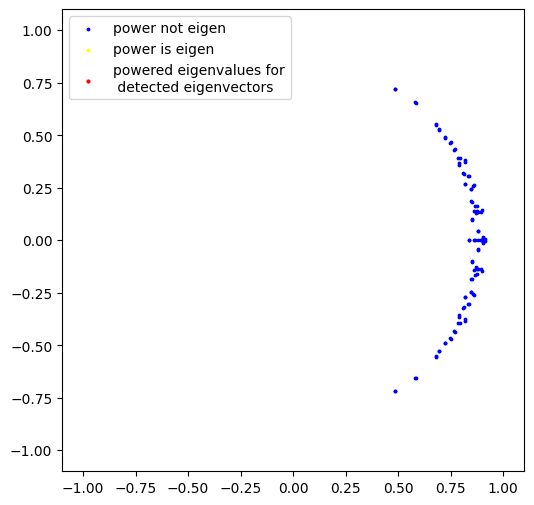

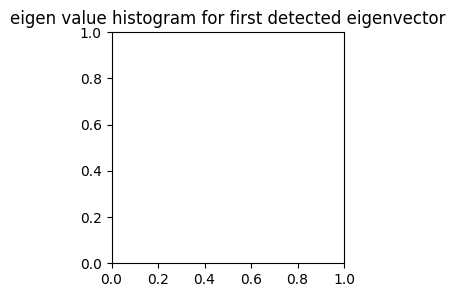

In [66]:
check_exponent_eigenvectors(koopman_matrix, koopman_eigvecs, koopman_eigvals, exponent=4)

In [68]:
def check_multiplied_eigenvectors(koopman_matrix, koopman_eigvecs, koopman_eigvals):
    print("is eigenvector?", check_is_eigenvector(koopman_matrix, koopman_eigvecs[:, 0])[0]) # should be ok
    is_eigenvector = []

    # get which eigenvectors have their squares as eigenvectors
    for i, j in zip(range(koopman_eigvecs.shape[1]), range(koopman_eigvecs.shape[1])):
        if i == j:
            continue
        is_eigenvector.append(check_is_eigenvector(koopman_matrix, koopman_eigvecs[:,i]*koopman_eigvecs[:,j])[0])

    print("No. of pairwise multiplications that are eigenvectors: ", sum(is_eigenvector))
    # TO DO: write code to plot when more than 0 eigenvectors detected




#### check if pairwise multiplications of eigenvectors are eigenvectors

In [69]:
check_multiplied_eigenvectors(koopman_matrix, koopman_eigvecs, koopman_eigvals)

is eigenvector? True
No. of pairwise multiplications that are eigenvectors:  0


### check if a function is an eigenfunction of the operator

check the equation $\phi_i(T(t)) = \lambda_i \phi_i(t)$ where T is the flow map for koopman eigenfunction $\phi_i$

#### check without any exponentiation

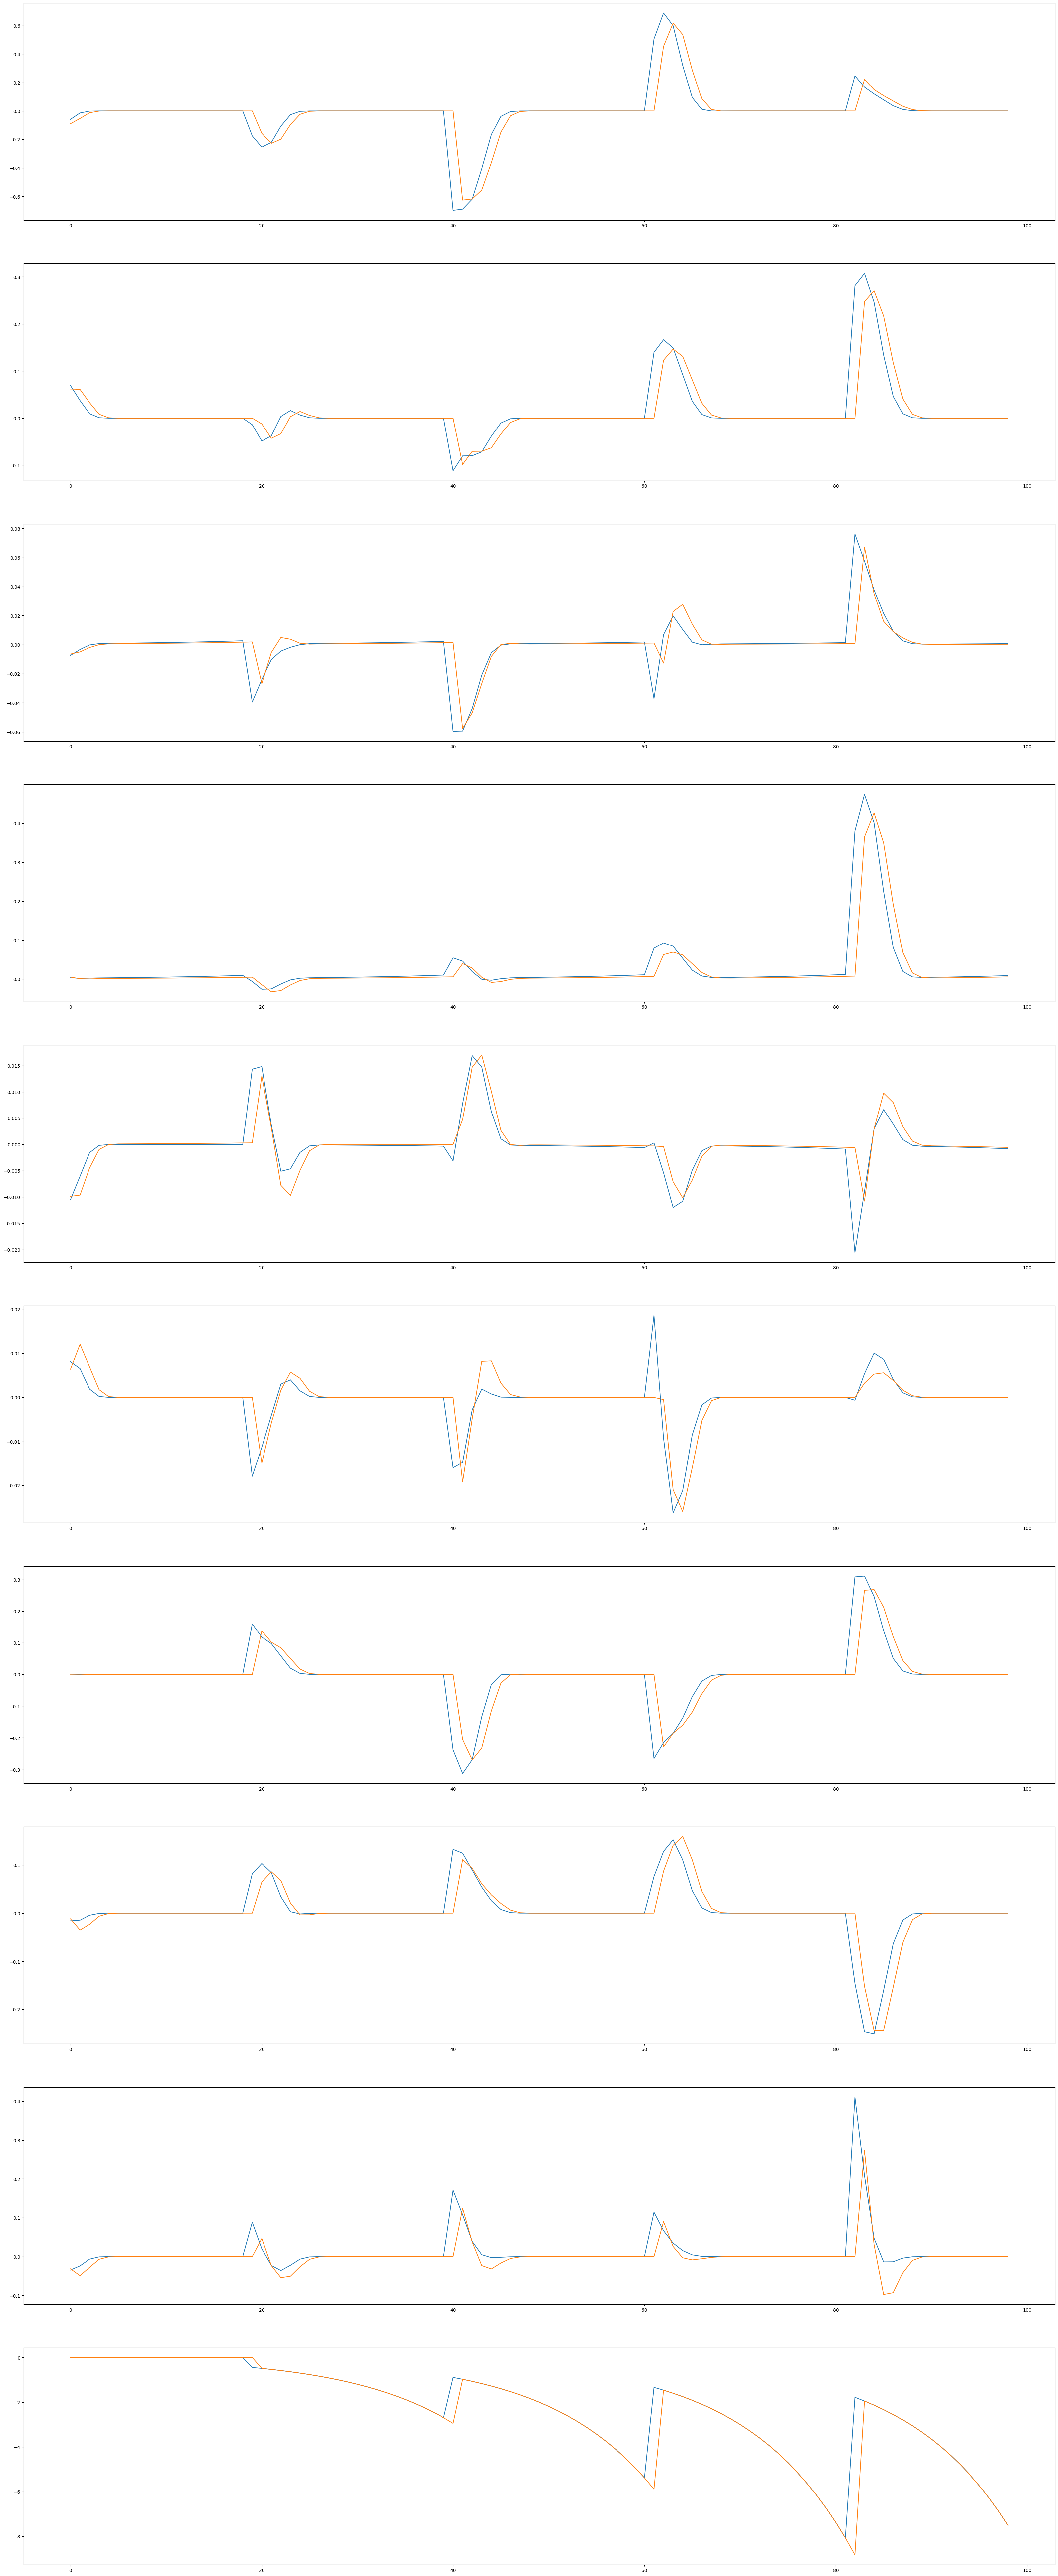

In [70]:
fig, ax = fig, ax = plt.subplots(10, 1, figsize=(40,100))
np.random.seed(10)
for i, eigvalue_ind in enumerate([np.random.randint(koopman_eigvals.shape[0]) for i in range(10)]):   
    ax[i].plot(np.array(edmd_rbf.koopman_eigenfunction(tsc_data.iloc[2:101,]).iloc[:,eigvalue_ind]).real)
    ax[i].plot(np.array(edmd_rbf.koopman_eigenvalues[eigvalue_ind] * 
                        edmd_rbf.koopman_eigenfunction(tsc_data.iloc[1:100,:]).iloc[:,eigvalue_ind]).real)
    

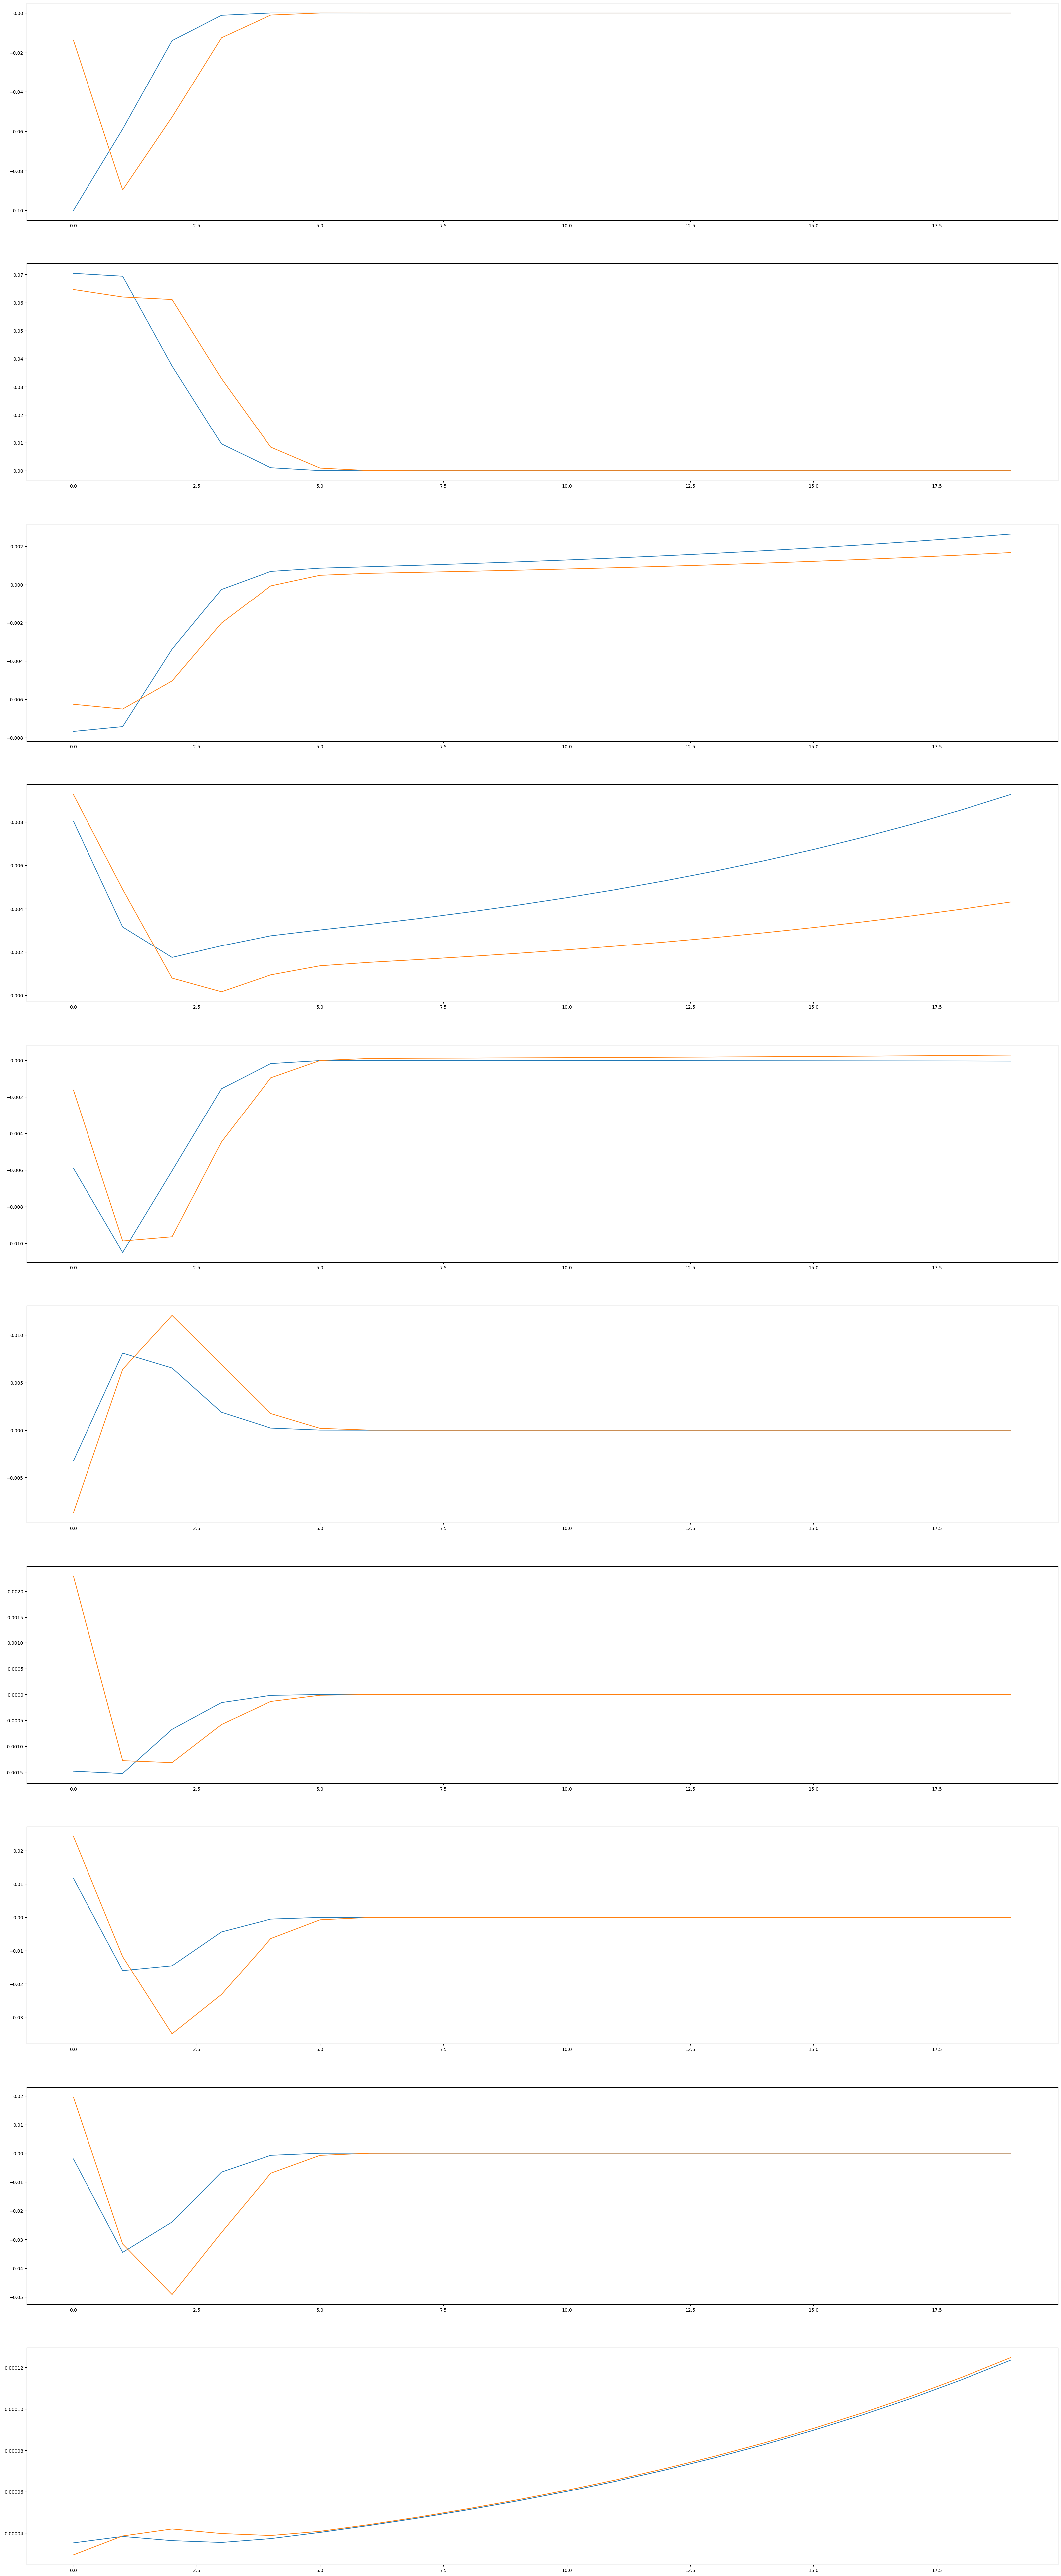

In [71]:
fig, ax = fig, ax = plt.subplots(10, 1, figsize=(40,100))
np.random.seed(10)
for i, eigvalue_ind in enumerate([np.random.randint(koopman_eigvals.shape[0]) for i in range(10)]):   
    ax[i].plot(np.array(edmd_rbf.koopman_eigenfunction(tsc_data.iloc[1:21,:]).iloc[:,eigvalue_ind]).real)
    ax[i].plot(np.array(edmd_rbf.koopman_eigenvalues[eigvalue_ind] * 
                        edmd_rbf.koopman_eigenfunction(tsc_data.iloc[0:20,:]).iloc[:,eigvalue_ind]).real)
    

#### exponent 2

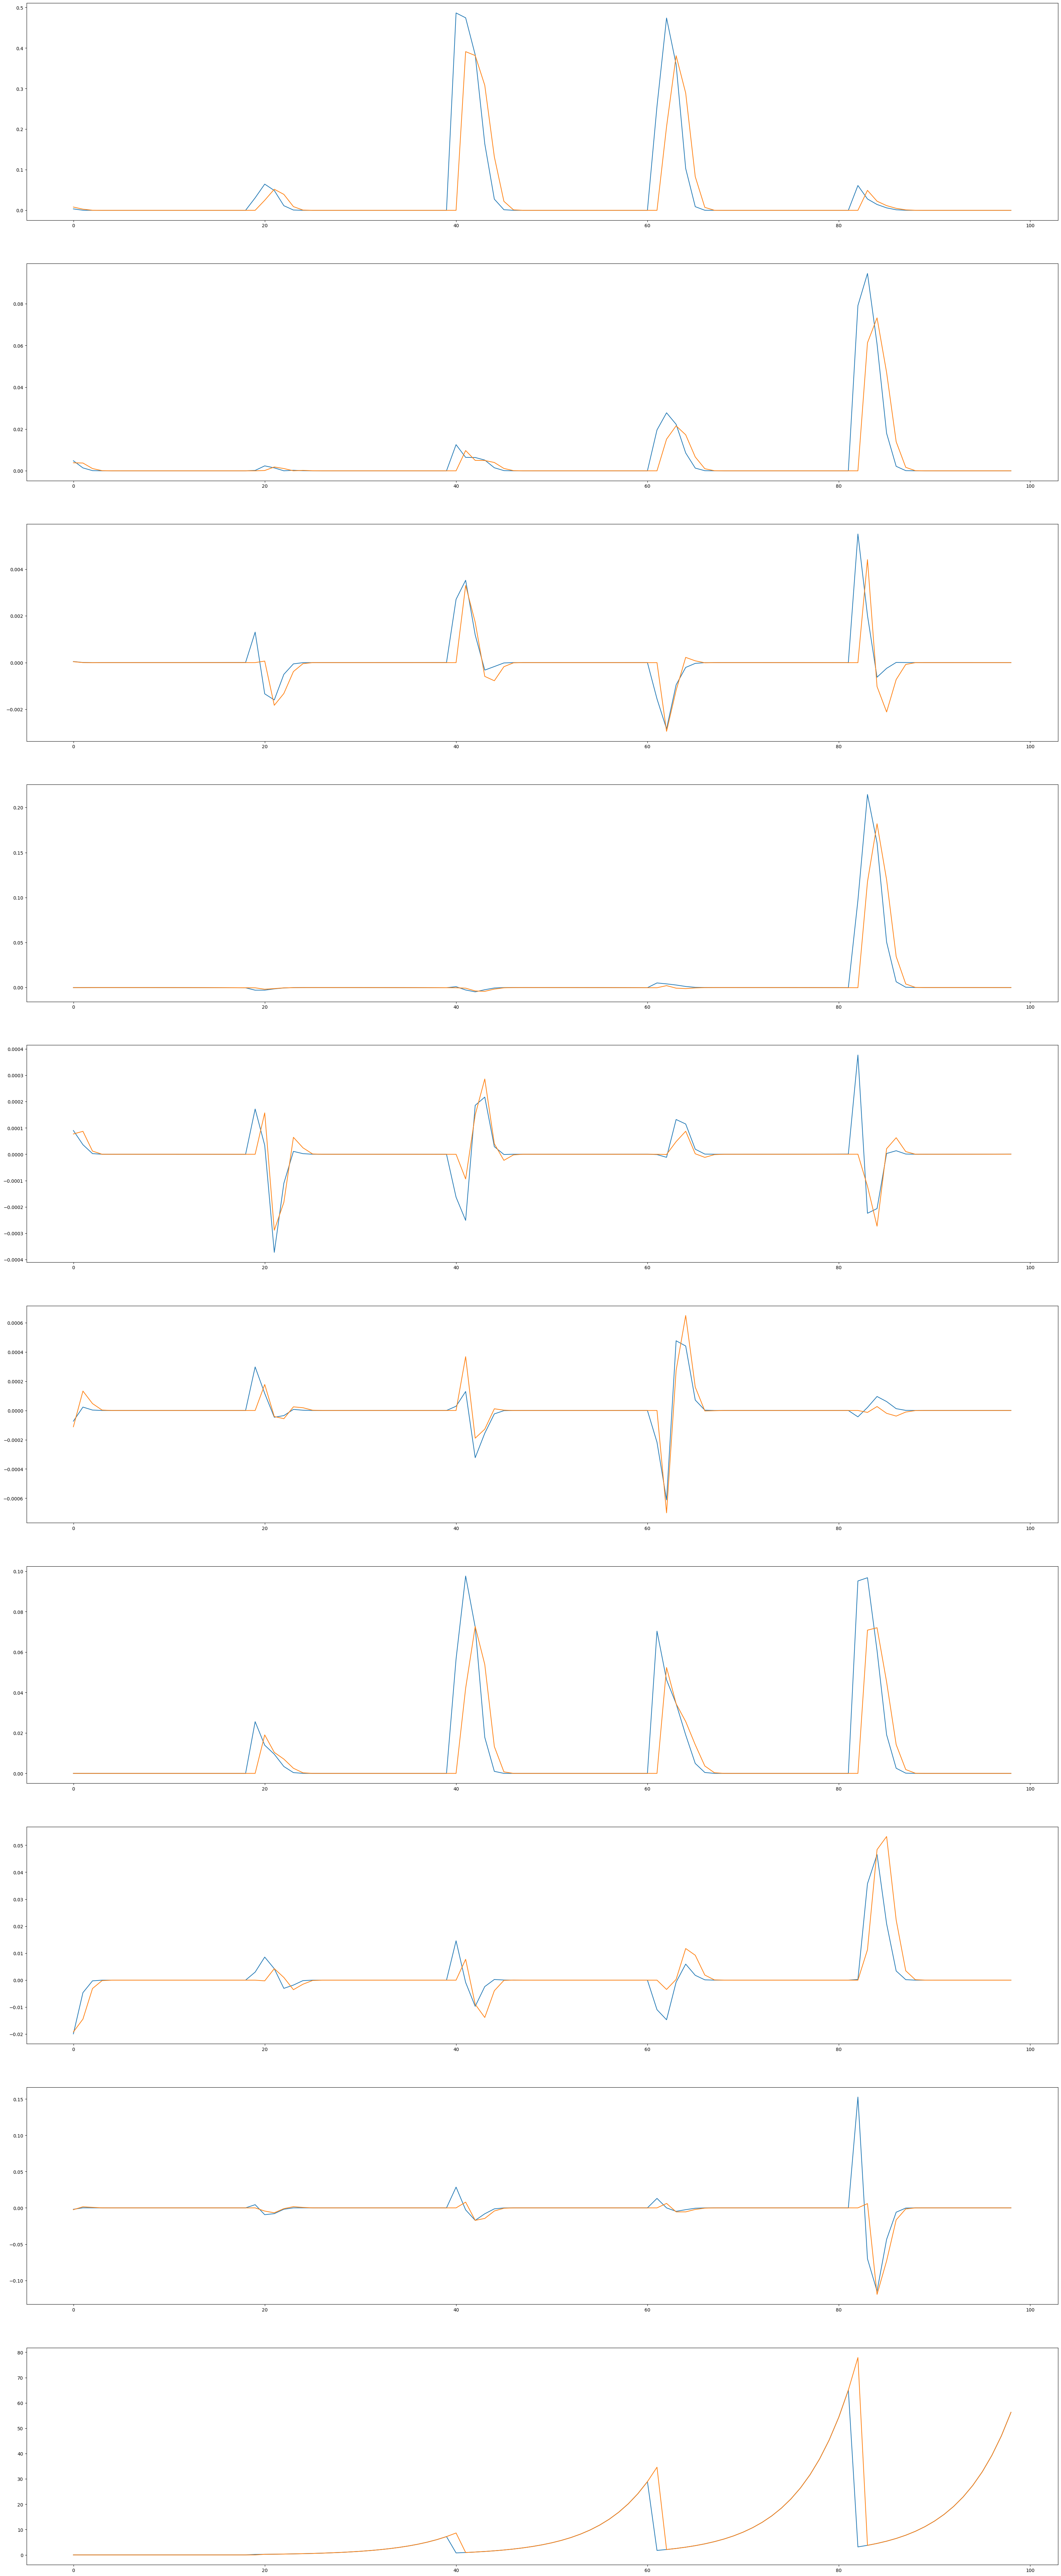

In [72]:
fig, ax = fig, ax = plt.subplots(10, 1, figsize=(40,100))
np.random.seed(10)
eigenfunction_pow = edmd_rbf.koopman_eigenfunction(tsc_data.iloc[1:100,:])**2
eigfunction_pow_shifted = edmd_rbf.koopman_eigenfunction(tsc_data.iloc[2:101,]) **2

for i, eigvalue_ind in enumerate([np.random.randint(koopman_eigvals.shape[0]) for i in range(10)]):  
    eigvalue_pow = edmd_rbf.koopman_eigenvalues[eigvalue_ind] **2
    
    ax[i].plot(np.array(eigfunction_pow_shifted.iloc[:,eigvalue_ind]).real)
    ax[i].plot(np.array(eigvalue_pow * eigenfunction_pow.iloc[:,eigvalue_ind]).real)
    

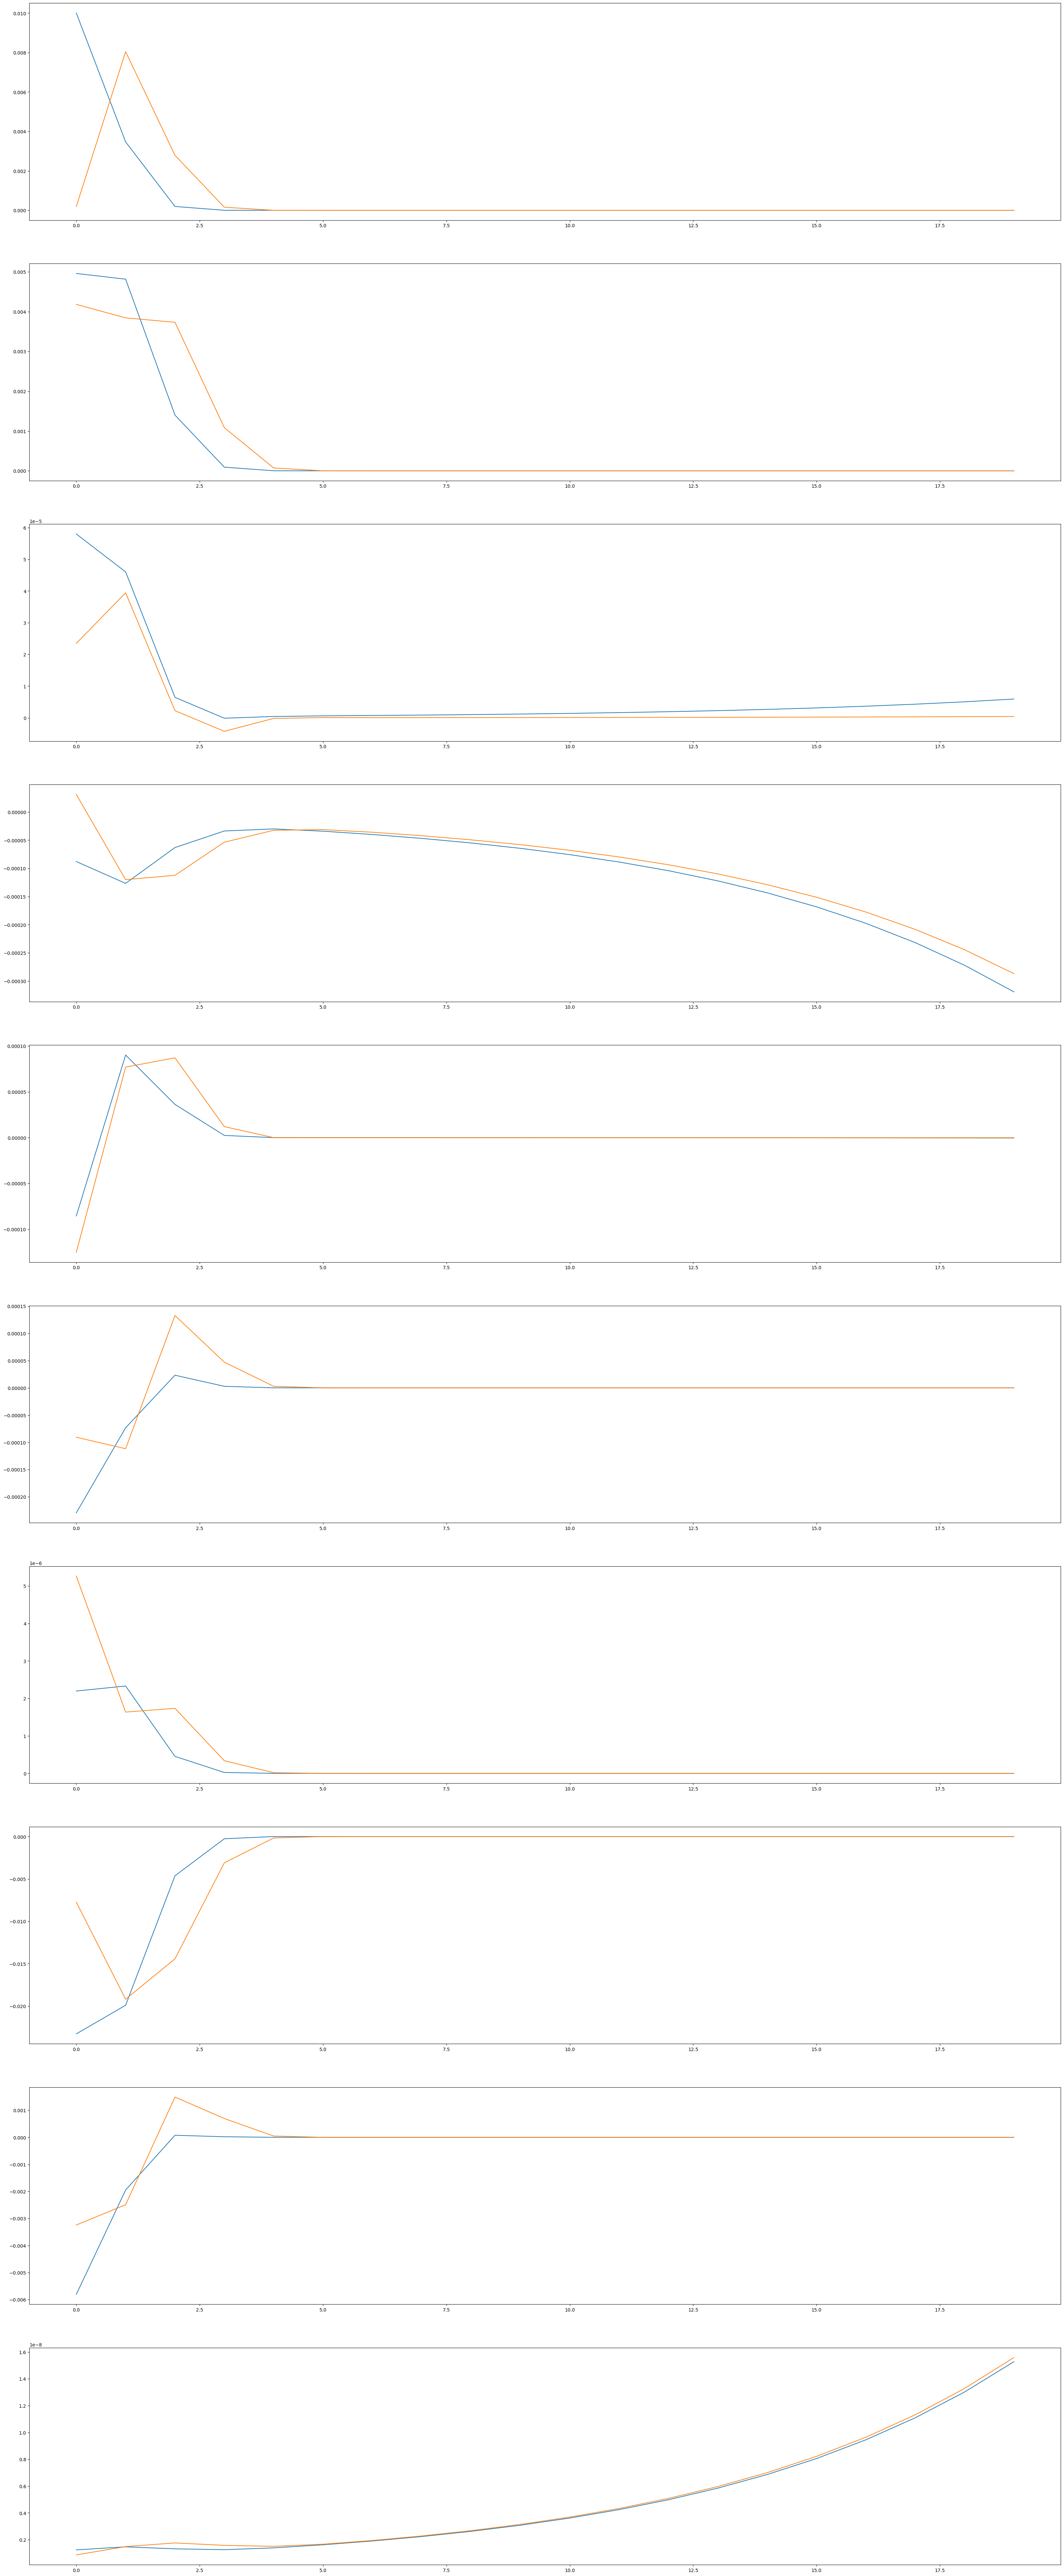

In [73]:
fig, ax = fig, ax = plt.subplots(10, 1, figsize=(40,100))
np.random.seed(10)
eigenfunction_pow = edmd_rbf.koopman_eigenfunction(tsc_data.iloc[0:20,:])**2
eigfunction_pow_shifted = edmd_rbf.koopman_eigenfunction(tsc_data.iloc[1:21,]) **2

for i, eigvalue_ind in enumerate([np.random.randint(koopman_eigvals.shape[0]) for i in range(10)]):  
    eigvalue_pow = edmd_rbf.koopman_eigenvalues[eigvalue_ind] **2
    
    ax[i].plot(np.array(eigfunction_pow_shifted.iloc[:,eigvalue_ind]).real)
    ax[i].plot(np.array(eigvalue_pow * eigenfunction_pow.iloc[:,eigvalue_ind]).real)
    

In [178]:
tsc_data.shape

(2100, 2)

In [180]:
shift_start_transposed, shift_end_transposed = tsc_data.tsc.shift_matrices(
            snapshot_orientation="row"
        )
shift_start_transposed.shape, shift_end_transposed.shape

((2000, 2), (2000, 2))

In [213]:
tsc_data.iloc[0:20]

feature        x1        x2
ID time                    
0  0.0  -2.000000 -2.000000
   0.1  -1.790341 -2.189675
   0.2  -1.562777 -2.357631
   0.3  -1.319615 -2.502191
   0.4  -1.063308 -2.621736
   0.5  -0.796391 -2.714968
   0.6  -0.521480 -2.780907
   0.7  -0.241269 -2.818896
   0.8   0.041465 -2.828596
   0.9   0.323864 -2.809989
   1.0   0.602992 -2.763377
   1.1   0.875939 -2.689360
   1.2   1.140279 -2.588628
   1.3   1.393256 -2.462098
   1.4   1.632231 -2.310950
   1.5   1.854782 -2.136615
   1.6   2.058699 -1.940777
   1.7   2.241986 -1.725371
   1.8   2.402860 -1.492586
   1.9   2.539753 -1.244864

In [214]:
tsc_data.iloc[1:21]

feature        x1        x2
ID time                    
0  0.1  -1.790341 -2.189675
   0.2  -1.562777 -2.357631
   0.3  -1.319615 -2.502191
   0.4  -1.063308 -2.621736
   0.5  -0.796391 -2.714968
   0.6  -0.521480 -2.780907
   0.7  -0.241269 -2.818896
   0.8   0.041465 -2.828596
   0.9   0.323864 -2.809989
   1.0   0.602992 -2.763377
   1.1   0.875939 -2.689360
   1.2   1.140279 -2.588628
   1.3   1.393256 -2.462098
   1.4   1.632231 -2.310950
   1.5   1.854782 -2.136615
   1.6   2.058699 -1.940777
   1.7   2.241986 -1.725371
   1.8   2.402860 -1.492586
   1.9   2.539753 -1.244864
   2.0   2.651309 -0.984895

In [205]:
edmd_rbf.koopman_eigenfunction(pd.DataFrame(shift_start_transposed, columns = ["x1", "x2"]))

AssertionError: Index are different

Attribute "names" are different
[left]:  [None]
[right]: ['feature']

In [198]:
shift_end_transposed[0:25,:]

array([[-1.7903415 , -2.18967516],
       [-1.56277713, -2.3576311 ],
       [-1.31961462, -2.50219122],
       [-1.06330779, -2.62173647],
       [-0.79639106, -2.71496803],
       [-0.52147951, -2.78090731],
       [-0.24126882, -2.81889592],
       [ 0.04146469, -2.82859572],
       [ 0.32386409, -2.80998878],
       [ 0.60299182, -2.7633774 ],
       [ 0.87593867, -2.68935979],
       [ 1.14027949, -2.58862785],
       [ 1.39325581, -2.46209816],
       [ 1.63223095, -2.31094999],
       [ 1.85478176, -2.13661486],
       [ 2.05869864, -1.94077652],
       [ 2.24198555, -1.72537099],
       [ 2.40286   , -1.49258649],
       [ 2.53975306, -1.24486353],
       [ 2.65130934, -0.98489483],
       [-1.8347119 , -1.74745112],
       [-1.65109387, -1.92203008],
       [-1.45101057, -2.0775395 ],
       [-1.23646294, -2.21227118],
       [-1.00955975, -2.32479197]])

#### exponent 3

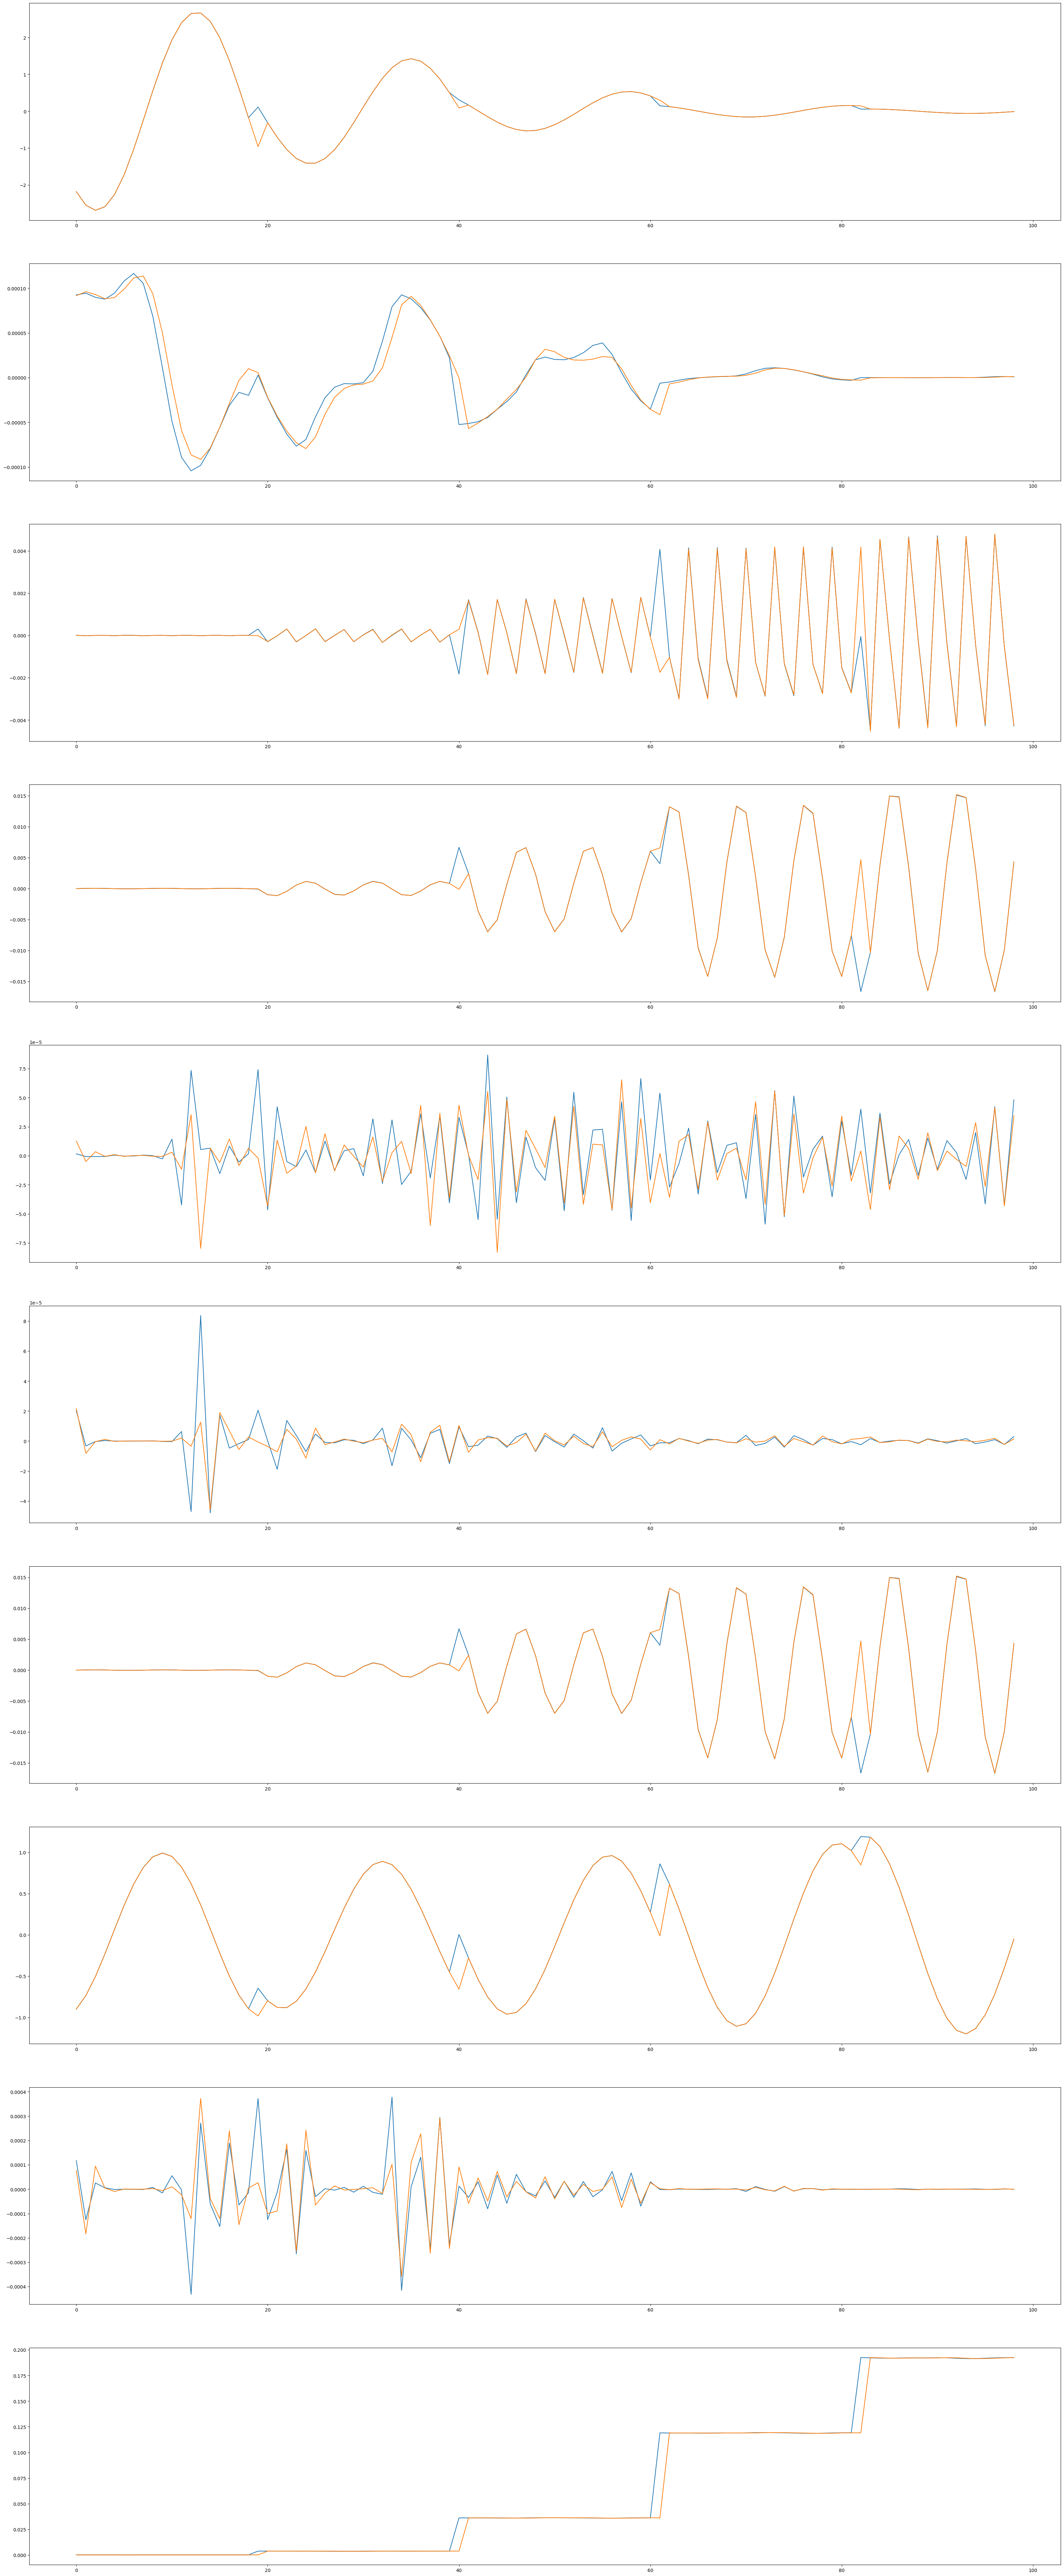

In [29]:
fig, ax = fig, ax = plt.subplots(10, 1, figsize=(40,100))
np.random.seed(10)
eigenfunction_pow = edmd_rbf.koopman_eigenfunction(tsc_data.iloc[1:100,:])**3
eigfunction_pow_shifted = edmd_rbf.koopman_eigenfunction(tsc_data.iloc[2:101,]) **3

for i, eigvalue_ind in enumerate([np.random.randint(koopman_eigvals.shape[0]) for i in range(10)]):  
    eigvalue_pow = edmd_rbf.koopman_eigenvalues[eigvalue_ind] **3
    
    ax[i].plot(np.array(eigfunction_pow_shifted.iloc[:,eigvalue_ind]).real)
    ax[i].plot(np.array(eigvalue_pow * eigenfunction_pow.iloc[:,eigvalue_ind]).real)
    

### Power iteration and inverse iteration on Koopman matrix

In [30]:
koopman_matrix.shape

(100, 100)

In [133]:
def power_iteration(A, max_iterations = 100000, tolerance=1e-8):
    eig_old = 0
    x = np.random.rand(A.shape[1])
    x = x/np.linalg.norm(x)
    for i in range(max_iterations):
        y = np.dot(A, x)
        norm = np.linalg.norm(y)
        x = y / norm 
        eigenvalue = np.dot(np.dot(x, A), x.T)
        if np.abs(eig_old - eigenvalue) < tolerance:
            return x, eigenvalue
        else:
            eig_old = eigenvalue
    
    print("max iter reached", eig_old - eigenvalue)
    return x, eigenvalue

In [137]:
def power_iteration_with_deflation(A, num_eigen, num_iterations, tolerance=1e-8):
    eigs = []
    
    for i in range(num_eigen):
        eigvec, eigvalue = power_iteration(A, num_iterations, tolerance)
        eigs.append((eigvec, eigvalue))
        A = A - eigvec@eigvec.T
    
    return eigs

In [138]:
eig_pairs_pi = power_iteration_with_deflation(koopman_matrix, 10, 10000, tolerance=1e-7)
[l[1] for l in eig_pairs_pi]

[0.9934791726453274,
 -99.00701839973095,
 -199.00705491339698,
 -299.0070670206315,
 -399.00707306230584,
 -499.0070766834597,
 -599.0070790959376,
 -699.0070808186463,
 -799.0070821099964,
 -899.0070831140595]

totally unstable after deflation

#### try deflation for asymmetric matriceS

In [139]:
def power_iteration_with_deflation_asymm(A, num_eigen, num_iterations, tolerance=1e-8):
    eigs = []
    
    for i in range(num_eigen):
        print(f"eigenvalue {i+1}")
        v, l = power_iteration(A, num_iterations, tolerance)
        f, l_d = power_iteration(A.T, num_iterations, tolerance)
        
        v = v.reshape(v.shape[0],1)
        f = f.reshape(f.shape[0],1)
        
        f_norm = f/(f.T@v)
        
        print("f^Tv: ", f_norm.T@v) 
        print("---------")
        eigs.append((v, l))
        A = A - l * v @ f.T
    
    return eigs

In [140]:
eig_pairs_pi = power_iteration_with_deflation_asymm(koopman_matrix, 10, 10000, tolerance=1e-7)

eigenvalue 1
max iter reached 0.0
f^Tv:  [[1.]]
---------
eigenvalue 2
max iter reached 0.0
f^Tv:  [[1.]]
---------
eigenvalue 3
max iter reached 0.0
max iter reached 0.0
f^Tv:  [[1.]]
---------
eigenvalue 4
max iter reached 0.0
max iter reached 0.0
f^Tv:  [[1.]]
---------
eigenvalue 5
f^Tv:  [[1.]]
---------
eigenvalue 6
f^Tv:  [[1.]]
---------
eigenvalue 7
f^Tv:  [[1.]]
---------
eigenvalue 8
max iter reached 0.0
max iter reached 0.0
f^Tv:  [[1.]]
---------
eigenvalue 9
max iter reached 0.0
max iter reached 0.0
f^Tv:  [[1.]]
---------
eigenvalue 10
max iter reached 0.0
max iter reached 0.0
f^Tv:  [[1.]]
---------


In [141]:
[l[1] for l in eig_pairs_pi]

[0.9932688000283292,
 0.9090326572310812,
 0.9989267925741869,
 1.0717909084836474,
 1.2880539925520709,
 1.0424411524688508,
 1.2412235401786123,
 0.7786653616798729,
 1.3759442127297068,
 0.9434060855694126]

some eigenvalues greater than 1 and 2? and eigenvalues nor ordered in this iteration?

#### run inverse iteration on \lambda_1 . \lambda_2

In [159]:
eig_new = eig_pairs_pi[0][1] * eig_pairs_pi[1][1]
eig_new

0.9029137766344795

In [160]:
B = np.linalg.inv(koopman_matrix - eig_new)
B.shape

(100, 100)

In [164]:
power_iteration(B)

(array([ 2.19596740e-01, -8.30402764e-02,  1.09710608e-01, -1.27694347e-01,
         1.44383539e-01, -1.48912194e-01,  1.57738465e-01, -1.39229688e-01,
         2.78590526e-01, -2.19596740e-01, -2.78590526e-01,  2.53928705e-02,
        -1.25587787e-02,  6.67661442e-03,  3.94666558e-03, -1.02448942e-02,
         1.04748303e-02, -1.81237095e-02, -2.53928705e-02,  8.30402764e-02,
         1.39229688e-01,  1.81237095e-02, -9.33087735e-03,  5.13579967e-04,
        -5.08509379e-03,  5.50891680e-03, -3.55999400e-03,  9.33087735e-03,
         1.25587787e-02, -1.09710608e-01, -1.57738465e-01, -1.04748303e-02,
         3.55999400e-03,  6.87009259e-03, -3.55425621e-03,  4.11747636e-03,
        -6.87009259e-03, -5.13579969e-04, -6.67661442e-03,  1.27694347e-01,
         1.48912194e-01,  1.02448942e-02, -5.50891680e-03, -4.11747636e-03,
         2.14332853e-04, -2.14332856e-04,  3.55425621e-03,  5.08509379e-03,
        -3.94666558e-03, -1.44383539e-01, -1.44383539e-01, -3.94666558e-03,
         5.0

In [165]:
1/13.640918150536917 + eig_pairs_pi[0][1] * eig_pairs_pi[1][1]

0.9762226249806327

In [166]:
1/13.640918150536917 

0.07330884834615324